# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [5]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

requires **stationarity** so that initial steps from univariate time-series modelling carry over.

apply the augmented Dickey-Fuller test

In [6]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment (*and others*), both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1990 through 2024:

### Consumer Sentiment

university of Michigan

In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
sent = web.DataReader("UMCSENT", "fred", start, end)
print(sent)
print(sent.info())

            UMCSENT
DATE               
1990-01-01     93.0
1990-02-01     89.5
1990-03-01     91.3
1990-04-01     93.9
1990-05-01     90.6
...             ...
2023-09-01     67.8
2023-10-01     63.8
2023-11-01     61.3
2023-12-01     69.7
2024-01-01     79.0

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UMCSENT  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


### VIX tracking

volatility tracking S&P 500

In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
vix = web.DataReader("EMVMACROBUS", "fred", start, end)
print(vix)
print(vix.info())

            EMVMACROBUS
DATE                   
1990-01-01      0.19286
1990-02-01      0.29612
1990-03-01      0.04455
1990-04-01      0.24888
1990-05-01      0.16806
...                 ...
2023-09-01      0.37640
2023-10-01      0.00000
2023-11-01      0.00000
2023-12-01      0.00000
2024-01-01      0.53128

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMVMACROBUS  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


### Umich inflation expectation

In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
exp_inflation = web.DataReader("MICH", "fred", start, end)
print(exp_inflation)
print(exp_inflation.info())

            MICH
DATE            
1990-01-01   4.1
1990-02-01   4.1
1990-03-01   3.7
1990-04-01   3.6
1990-05-01   3.4
...          ...
2023-09-01   3.2
2023-10-01   4.2
2023-11-01   4.5
2023-12-01   3.1
2024-01-01   2.9

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MICH    409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


### cpi

https://fred.stlouisfed.org/series/CPIAUCSL

 Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCNS)

  Consumer Price Index: All Items: Total for United States (CPALTT01USM657N)



#### Sticky price CPI inflation

In [7]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
cpi_all = web.DataReader("STICKCPIM157SFRBATL", "fred", start, end)
print(cpi_all)
print(cpi_all.info())

            STICKCPIM157SFRBATL
DATE                           
1990-01-01             0.446445
1990-02-01             0.392597
1990-03-01             0.618123
1990-04-01             0.431722
1990-05-01             0.382620
...                         ...
2023-09-01             0.413800
2023-10-01             0.346680
2023-11-01             0.288530
2023-12-01             0.344810
2024-01-01             0.538316

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STICKCPIM157SFRBATL  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


#### Core inflation

In [8]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
cpi_core = web.DataReader("CORESTICKM159SFRBATL", "fred", start, end)
print(cpi_core)
print(cpi_core.info())

            CORESTICKM159SFRBATL
DATE                            
1990-01-01              4.905908
1990-02-01              4.917559
1990-03-01              5.191525
1990-04-01              5.276985
1990-05-01              5.166732
...                          ...
2023-09-01              4.959770
2023-10-01              4.882928
2023-11-01              4.688293
2023-12-01              4.554396
2024-01-01              4.603922

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CORESTICKM159SFRBATL  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


### (optional) break-even inflation

### PCE

In [9]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
pce = web.DataReader("PCEPILFE", "fred", start, end)
print(pce)
print(pce.info())

            PCEPILFE
DATE                
1990-01-01    59.181
1990-02-01    59.468
1990-03-01    59.754
1990-04-01    59.932
1990-05-01    60.115
...              ...
2023-09-01   119.842
2023-10-01   120.015
2023-11-01   120.122
2023-12-01   120.305
2024-01-01   120.849

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PCEPILFE  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


### Fundamental Interest Rate - Fed Funds Rate


In [10]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
fedfunds = web.DataReader("FEDFUNDS", "fred", start, end)
print(fedfunds)
print(fedfunds.info())

            FEDFUNDS
DATE                
1990-01-01      8.23
1990-02-01      8.24
1990-03-01      8.28
1990-04-01      8.26
1990-05-01      8.18
...              ...
2023-09-01      5.33
2023-10-01      5.33
2023-11-01      5.33
2023-12-01      5.33
2024-01-01      5.33

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


#### (optional) fed discount rate LIBOR rate

### GDP - Percent Change from Preceding Period,

GDP growth

In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
gdp = web.DataReader("A191RL1Q225SBEA", "fred", start, end)
print(gdp)

            A191RL1Q225SBEA
DATE                       
1990-01-01              4.4
1990-04-01              1.5
1990-07-01              0.3
1990-10-01             -3.6
1991-01-01             -1.9
...                     ...
2022-10-01              2.6
2023-01-01              2.2
2023-04-01              2.1
2023-07-01              4.9
2023-10-01              3.4

[136 rows x 1 columns]


### All Employees: Total Nonfarm in New York (SMS36000000000000026)


In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
payroll_ny = web.DataReader("SMS36000000000000026", "fred", start, end)
print(payroll_ny)
print(payroll_ny.info())

            SMS36000000000000026
DATE                            
1990-04-01                  -6.7
1990-05-01                  -2.7
1990-06-01                 -11.4
1990-07-01                 -11.8
1990-08-01                 -18.0
...                          ...
2023-09-01                   7.2
2023-10-01                   2.9
2023-11-01                  -0.4
2023-12-01                   4.3
2024-01-01                  21.7

[406 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406 entries, 1990-04-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SMS36000000000000026  406 non-null    float64
dtypes: float64(1)
memory usage: 6.3 KB
None


### All Employees: Total Nonfarm in San Francisco-Oakland-Hayward, CA (MSA)


In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
payroll_ca = web.DataReader("SMS06418600000000026", "fred", start, end)
print(payroll_ca)
print(payroll_ca.info())

            SMS06418600000000026
DATE                            
1990-04-01                   1.0
1990-05-01                   2.3
1990-06-01                   4.2
1990-07-01                   4.9
1990-08-01                   2.0
...                          ...
2023-09-01                  -1.2
2023-10-01                   3.2
2023-11-01                   4.9
2023-12-01                   5.7
2024-01-01                   2.0

[406 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406 entries, 1990-04-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SMS06418600000000026  406 non-null    float64
dtypes: float64(1)
memory usage: 6.3 KB
None


### Labor market indicators - labor force participation rate

$\frac{labor force population}{non-military workking-age population}$


In [ ]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 1, 1)
laborpart = web.DataReader("CIVPART", "fred", start, end)
print(laborpart)
print(laborpart.info())

            CIVPART
DATE               
1990-01-01     66.8
1990-02-01     66.7
1990-03-01     66.7
1990-04-01     66.6
1990-05-01     66.6
...             ...
2023-09-01     62.8
2023-10-01     62.7
2023-11-01     62.8
2023-12-01     62.5
2024-01-01     62.5

[409 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CIVPART  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


## Populate the dataframe

In [ ]:
df = pd.DataFrame()
df['pce'] = pce
df['FedFunds'] = fedfunds
df['headline_inflation'] = cpi_all
df['core_inflation'] = cpi_core
df['exp_inflation'] = exp_inflation
df['vix'] = vix
df['sent'] = sent

#df['payroll_ca'] = payroll_ca
#df['payroll_ny'] = payroll_ny
#df['laborpart'] = laborpart

print(df)
print(df.info())

                pce  FedFunds  headline_inflation  core_inflation  \
DATE                                                                
1990-01-01   59.181      8.23            0.446445        4.905908   
1990-02-01   59.468      8.24            0.392597        4.917559   
1990-03-01   59.754      8.28            0.618123        5.191525   
1990-04-01   59.932      8.26            0.431722        5.276985   
1990-05-01   60.115      8.18            0.382620        5.166732   
...             ...       ...                 ...             ...   
2023-09-01  119.842      5.33            0.413800        4.959770   
2023-10-01  120.015      5.33            0.346680        4.882928   
2023-11-01  120.122      5.33            0.288530        4.688293   
2023-12-01  120.305      5.33            0.344810        4.554396   
2024-01-01  120.849      5.33            0.538316        4.603922   

            exp_inflation      vix  sent  
DATE                                      
1990-01-01      

## Plot data

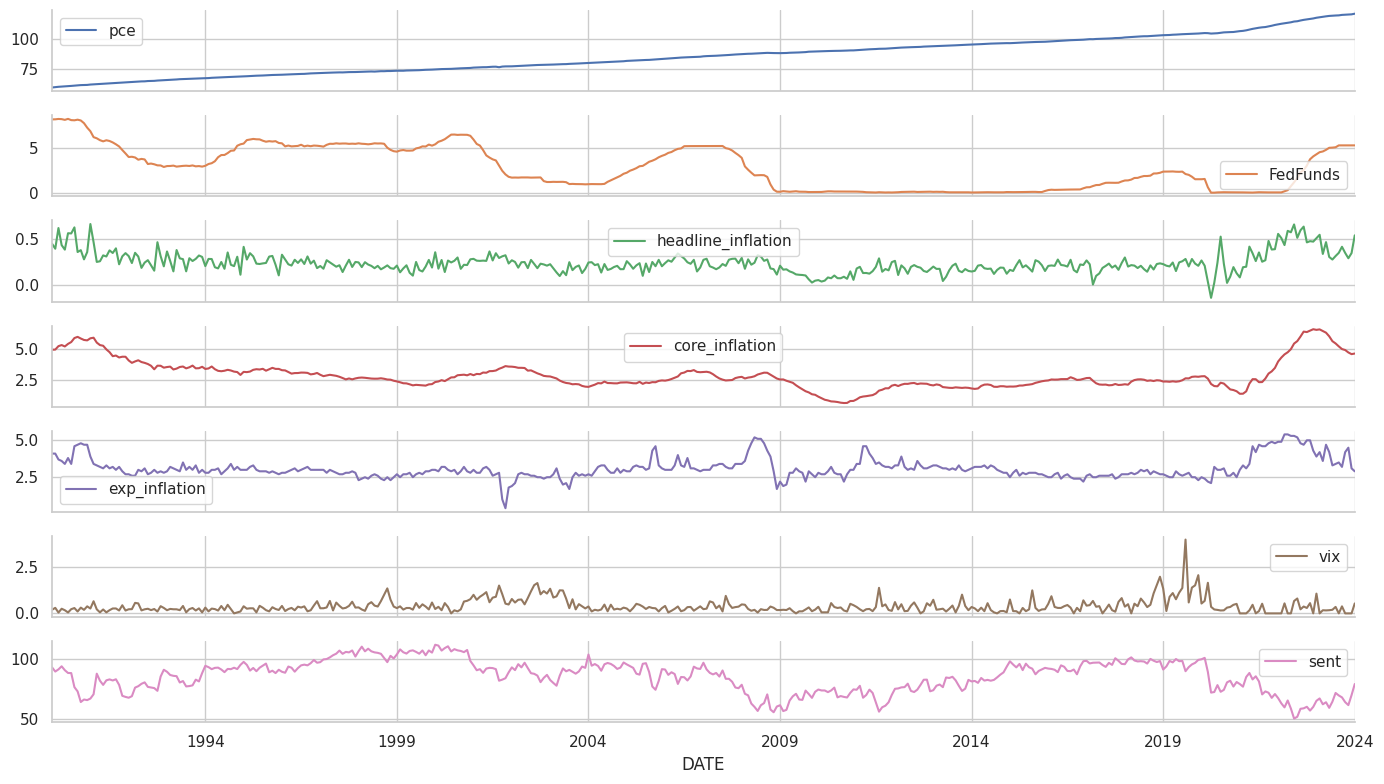

In [ ]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:


In [ ]:
df_transformed = pd.DataFrame({
                              'headline': np.log(df.headline_inflation).diff(10),
                              'core': np.log(df.core_inflation).diff(10),
                              #'PCE':  np.log(df.pce).diff(12),#.diff(),
                              'FedFunds': (df.FedFunds).diff(14),
                              'exp_inflation': np.log(df.exp_inflation).diff(9),
                              'sent': np.log(df.sent).diff(10),
                              'vix': df.vix.diff(12),

                              #'payroll_ca': np.log(df.payroll_ca).diff(12),
                              #'payroll_ny': np.log(df.payroll_ny).diff(12),
                              #'laborpart': np.log(df.laborpart).diff(12),

                              }).dropna()

## Inspect Correlograms

### ACF & PACF cutoff points under transformation ($p$ and $q$ for AR and MA terms)

### Sentiment
ACF cutoff @10, PACF cutoff @1

### Headline Inflation

ACF: cutoff @10, PACF cutoff @6?

### Core Inflation
ACF: cutoff @10, PACF cutoff @1?

### Fed Funds Rate (equiv to short-term LIBOR)

ACF cutoff @14, PACF cutoff @1

### PCE

ACF cutoff @14, PACF cutoff @1

### VIX

ACF cutoff @10, PACF cutoff @8

### sentiment

ACF cutoff @10, PACF cutoff @1

### Expected inflation

ACF cutoff @9, PACF cutoff @1



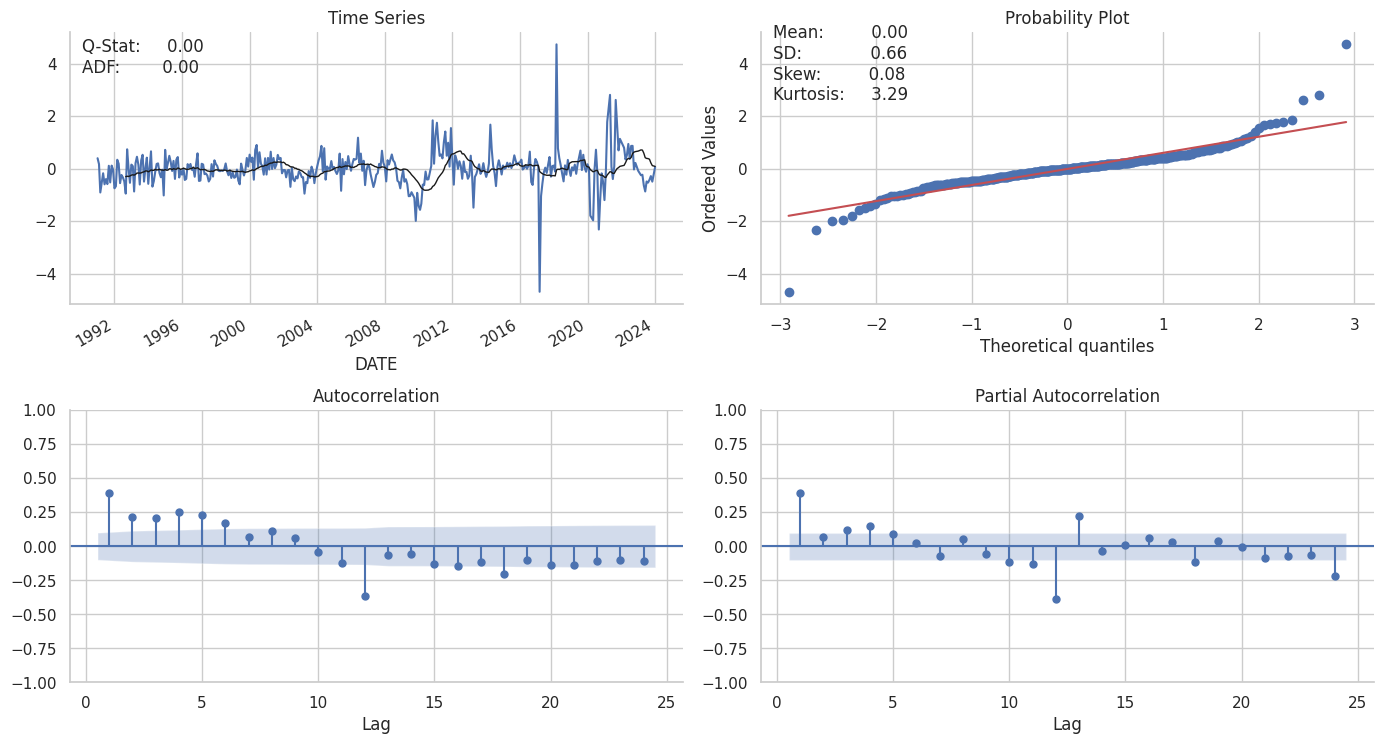

In [ ]:
plot_correlogram(df_transformed.headline, lags=24)

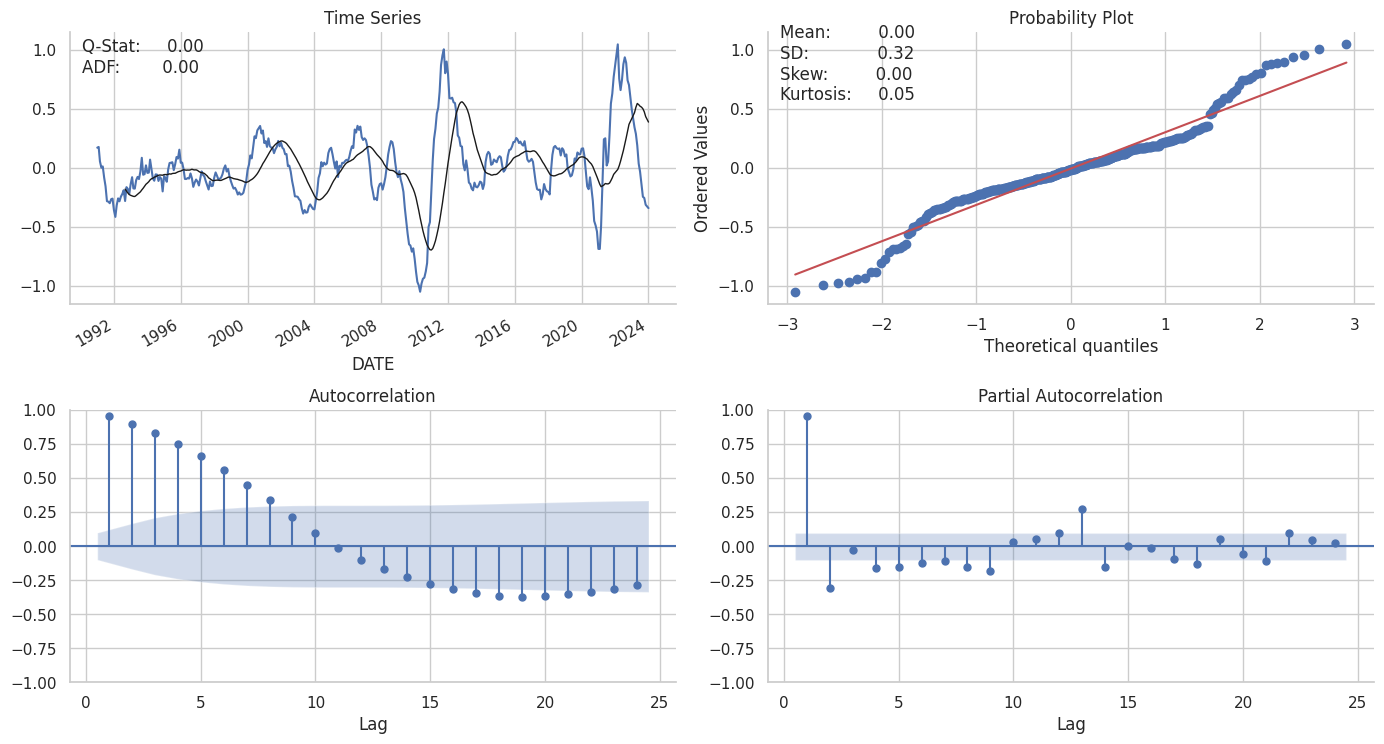

In [ ]:
plot_correlogram(df_transformed.core, lags=24)

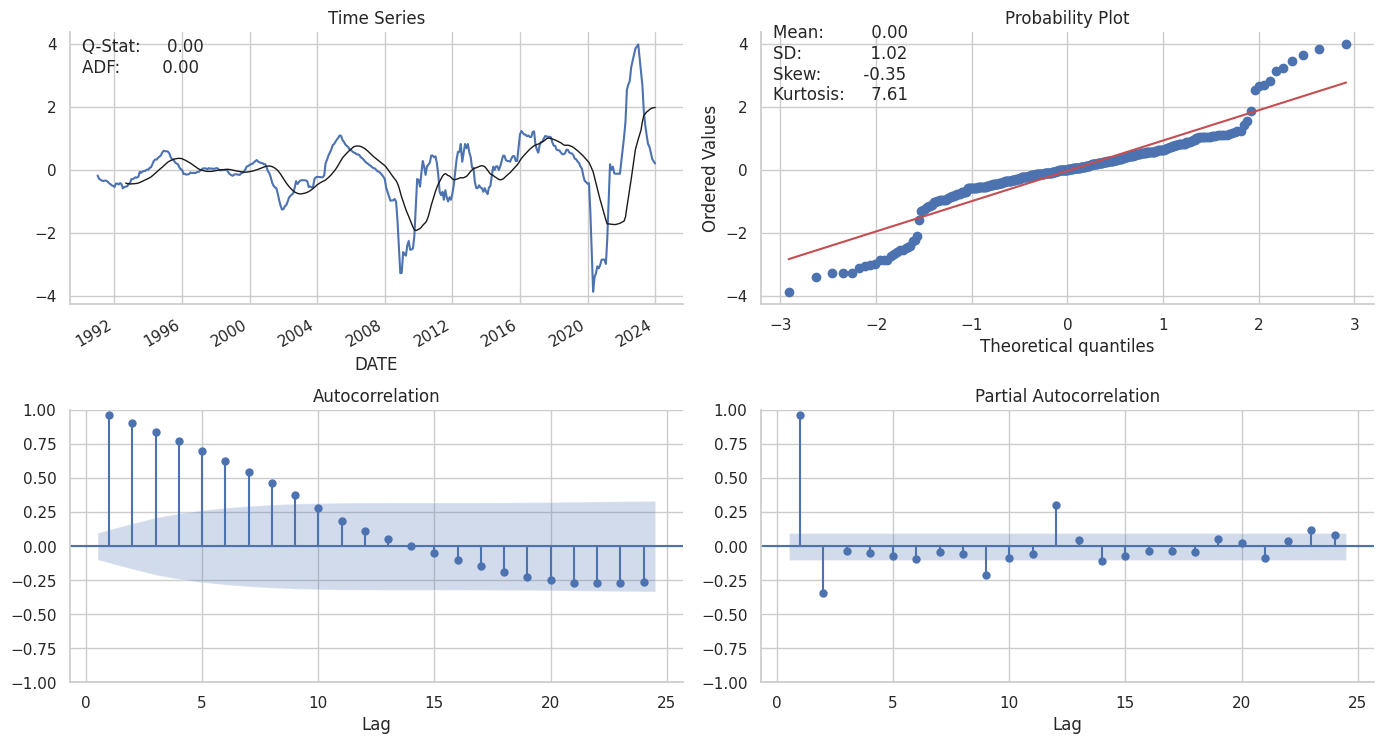

In [ ]:
plot_correlogram(df_transformed.FedFunds, lags=24)

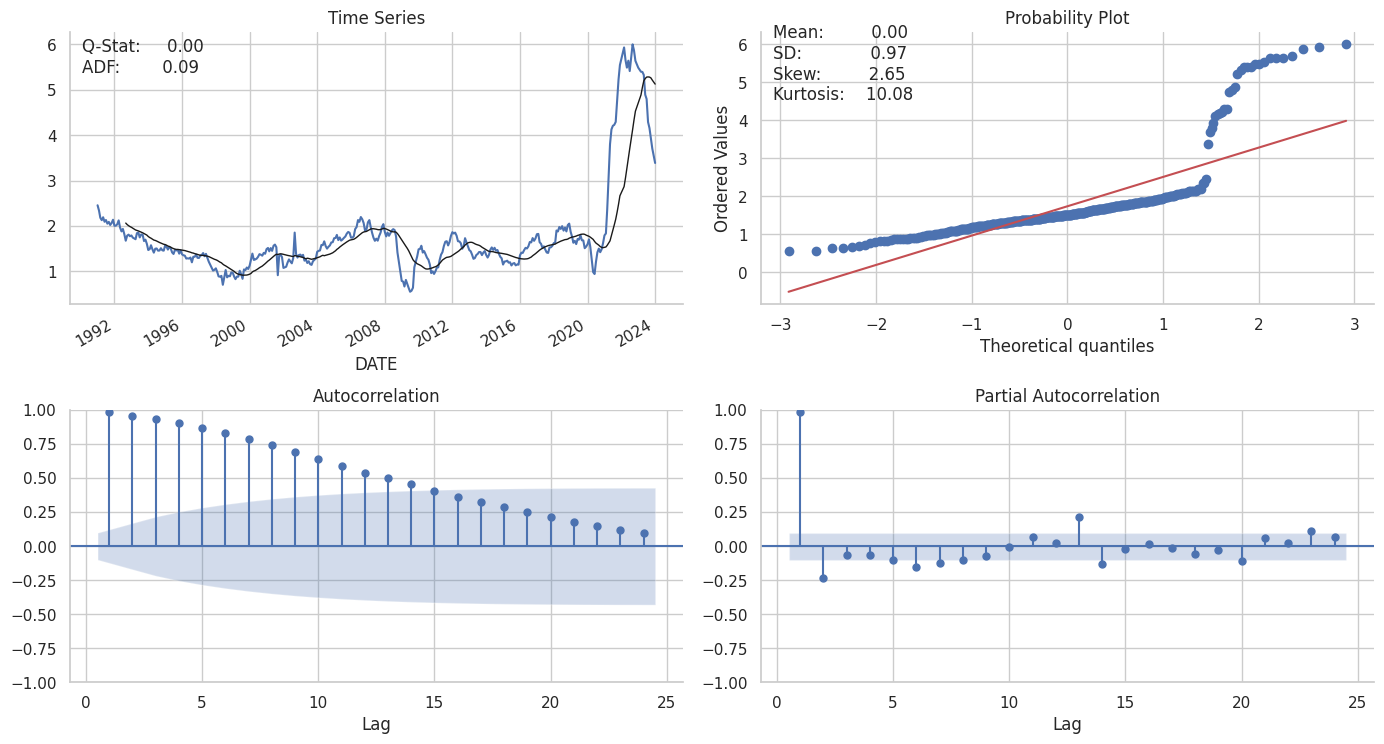

In [ ]:
plot_correlogram(df_transformed.PCE, lags=24)

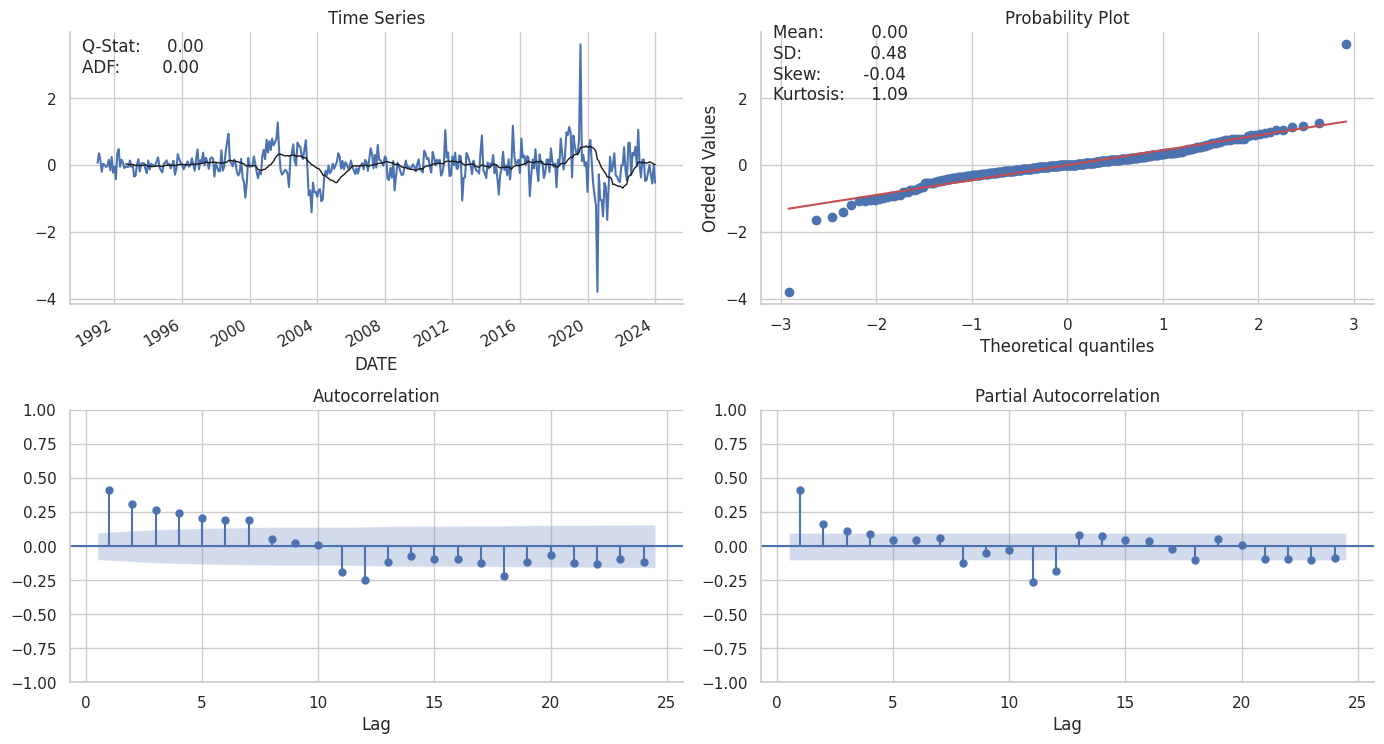

In [ ]:
plot_correlogram(df_transformed.vix, lags=24)

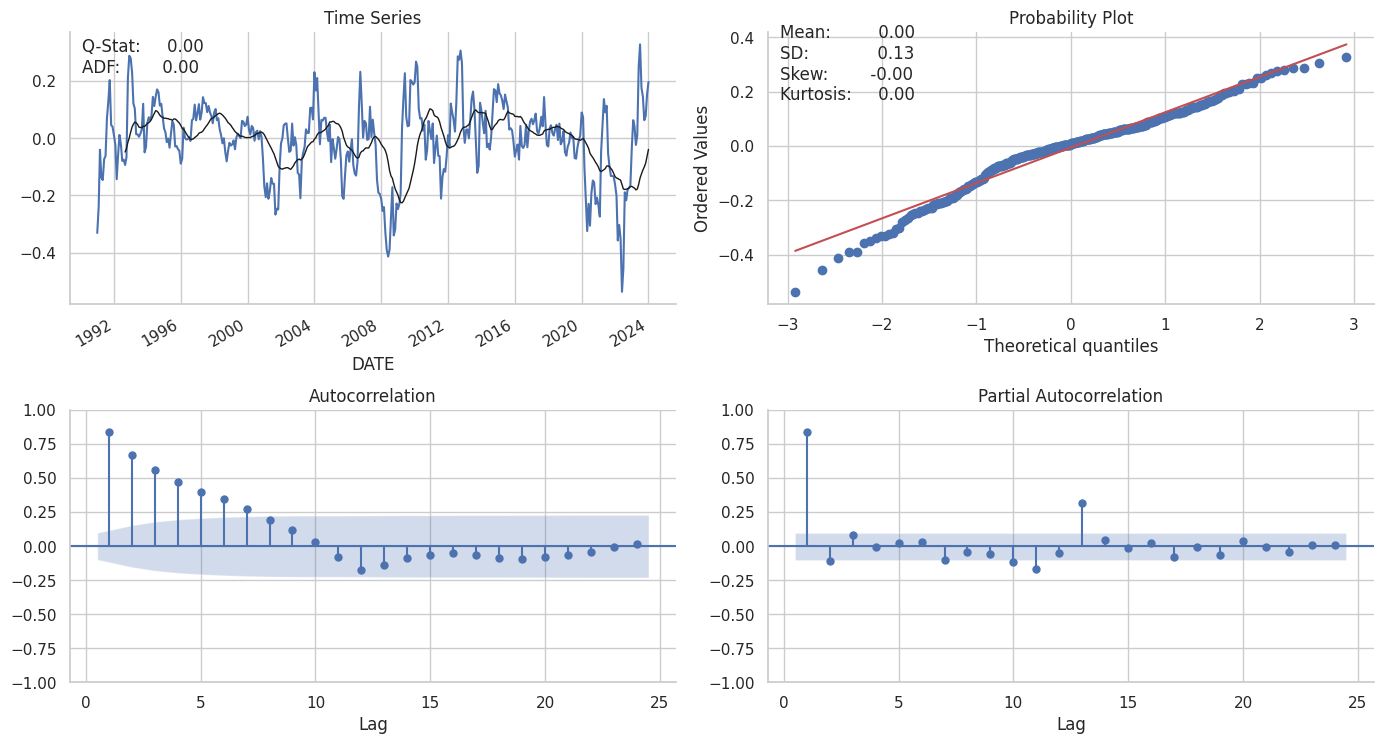

In [ ]:
plot_correlogram(df_transformed.sent, lags=24)

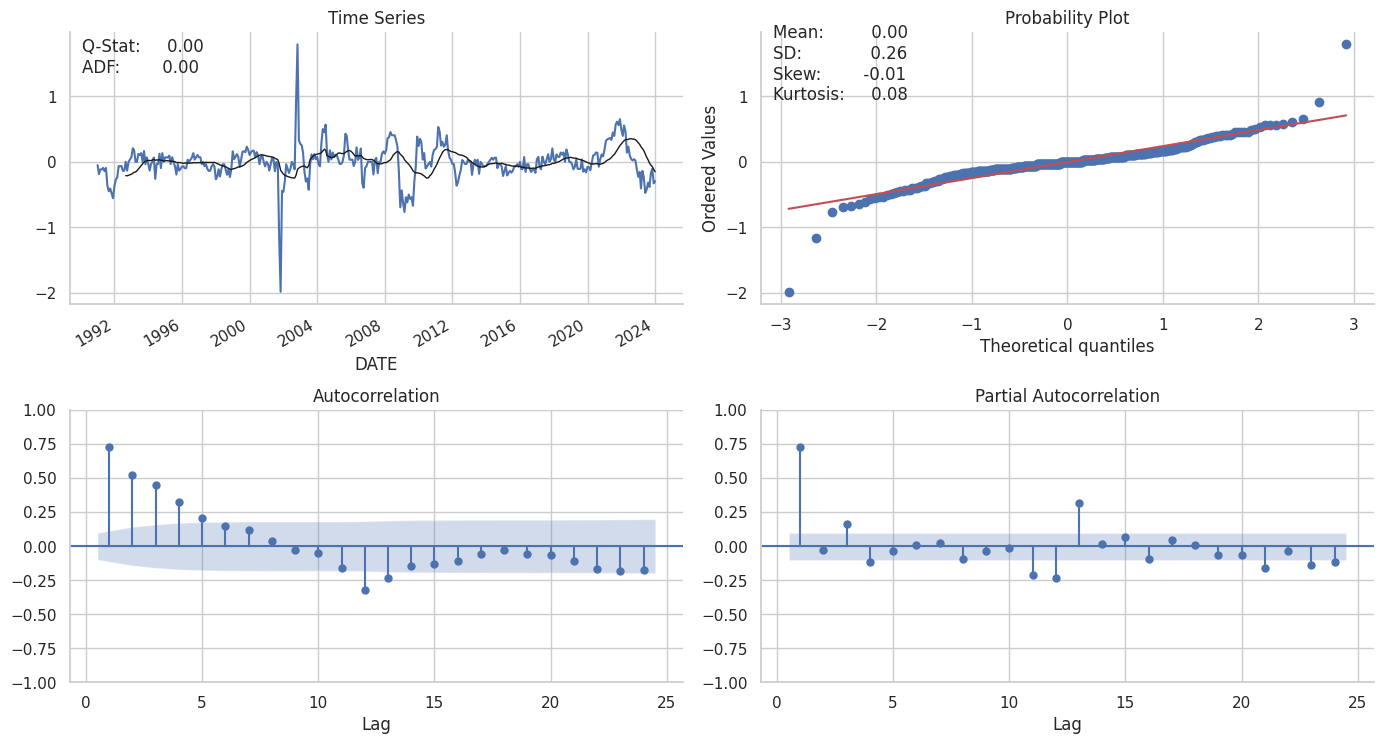

In [ ]:
plot_correlogram(df_transformed.exp_inflation, lags=24)

### this is the stationary test result

In [ ]:
test_unit_root(df_transformed)

p-value
headline        0.00%
core            0.00%
FedFunds        0.05%
exp_inflation   0.00%
sent            0.01%
vix             0.00%

### plot the transformed dataframe

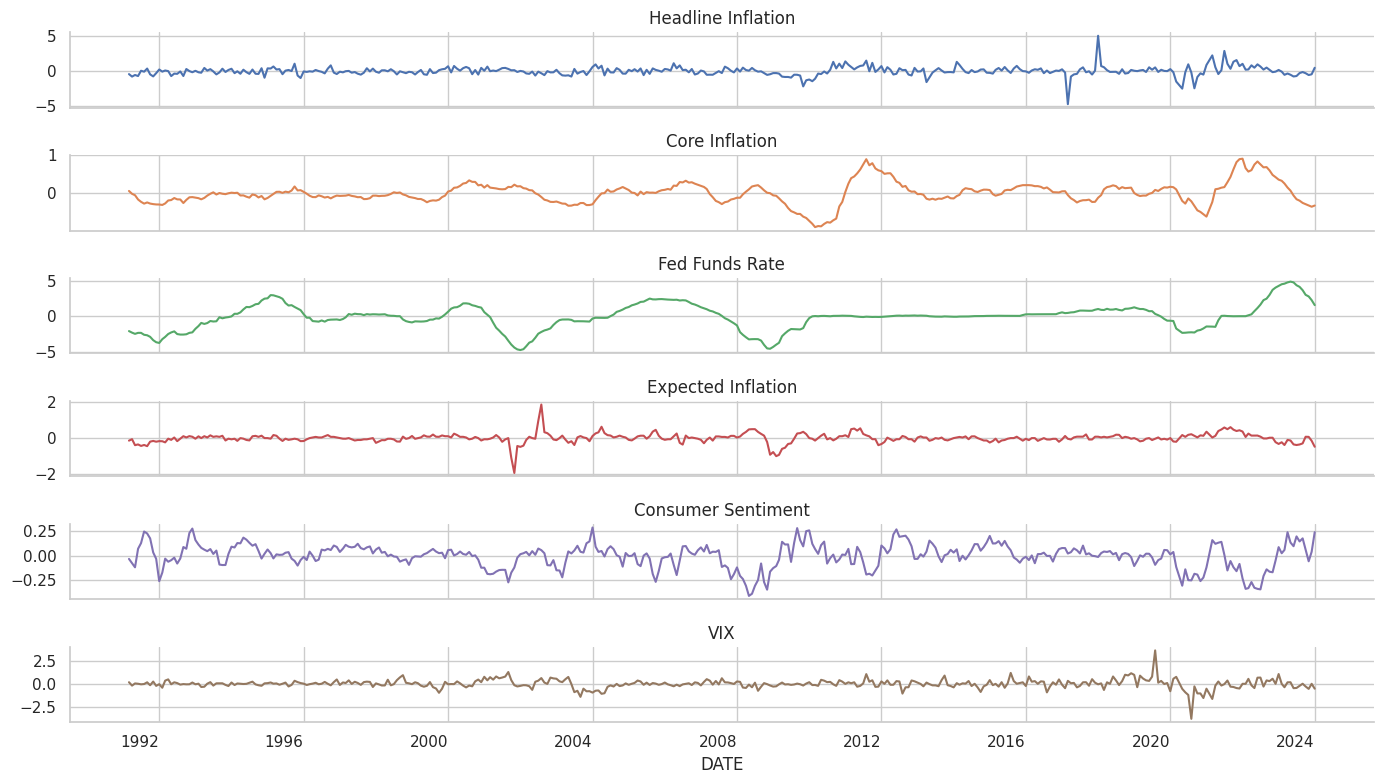

In [ ]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Headline Inflation', 'Core Inflation', 'Fed Funds Rate', 'Expected Inflation', 'Consumer Sentiment', 'VIX'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2024. The output contains the coefficients for both time series equations.

In [ ]:
print(df_transformed)
df_transformed = df_transformed.apply(minmax_scale)
test_unit_root(df_transformed)

In [ ]:
print(df_transformed.loc[:'2024'])

            headline      core  FedFunds  exp_inflation      sent      vix
DATE                                                                      
1991-03-01 -0.431756  0.057821     -2.11      -0.141079 -0.032532  0.17190
1991-04-01 -0.787494 -0.017759     -2.33      -0.060625 -0.076463 -0.19411
1991-05-01 -0.559406 -0.054797     -2.50      -0.394654 -0.119059  0.04081
1991-06-01 -0.708888 -0.167809     -2.36      -0.353640  0.071955  0.00584
1991-07-01  0.048664 -0.229673     -2.36      -0.437214  0.129919 -0.05407
...              ...       ...       ...            ...       ...      ...
2023-09-01 -0.137806 -0.258455      3.65      -0.295464  0.178788  0.00985
2023-10-01 -0.304565 -0.291912      3.00       0.074108  0.064748 -0.28980
2023-11-01 -0.564914 -0.324817      2.77       0.068993 -0.057068 -0.54907
2023-12-01 -0.457278 -0.359548      2.25      -0.149532  0.041001  0.00000
2024-01-01  0.472973 -0.327974      1.55      -0.482852  0.242313 -0.52610

[393 rows x 6 columns]


#### core & pce & fed funds AR MA

PACF lag = 1 ($p$)

ACF lag = 11 ($q$)

Taking average of the ACF cutoff points above

In [ ]:
model = VARMAX(df_transformed.loc[:'2024'], order=(1,11), trend='c').fit(maxiter=100, disp=True)

In [ ]:
print(model.summary())

                                                  Statespace Model Results                                                  
Dep. Variable:     ['headline', 'core', 'FedFunds', 'exp_inflation', 'sent', 'vix']   No. Observations:                  393
Model:                                                                  VARMA(1,11)   Log Likelihood                1173.961
                                                                        + intercept   AIC                          -1429.922
Date:                                                              Sat, 06 Apr 2024   BIC                            394.056
Time:                                                                      05:10:22   HQIC                          -707.103
Sample:                                                                           0                                         
                                                                              - 393                                         


### core inflation has a large Heteroskedasticity

### prep for out-of-sample forecast

In [ ]:
n =len(df_transformed)
start = n-12

preds = model.predict(start=start+1, end=start + 24)
# Get the start index from df_transformed
start_index = df_transformed.index[start:]
print(df_transformed.index[start:].shape)
print(preds)
print(df_transformed[start:])
# Get the start index from df_transformed
start_index = df_transformed.index[start:]

# Create a new index for preds using start_index values
new_index = pd.Index([start_index[i] for i in range(min(24, len(start_index)))])
print("new_index ", new_index)

extension_dates = pd.date_range(start='2024-02-01', periods=12, freq='MS')
print("extension ", extension_dates)
# Append the extension_dates to new_index
new_index = new_index.append(extension_dates)
print("new_index after ext ", new_index)
# Assign the new index to preds
preds.index = new_index
print(preds)

(12,)
     headline      core  FedFunds  exp_inflation      sent       vix
382  0.048817  0.279345  4.544658      -0.290406  0.088646 -0.181417
383 -0.209860  0.201248  4.711701      -0.157834  0.153037  0.036090
384 -0.369390  0.108513  4.829612       0.004804  0.224063  0.089086
385 -0.379968 -0.009452  4.713892      -0.217499  0.117150  0.066396
386 -0.723626 -0.148823  4.683316      -0.348891  0.145132  0.031734
387 -0.789494 -0.195879  4.259240      -0.261764  0.174029 -0.154783
388 -0.245337 -0.198895  3.827711      -0.167526  0.184856 -0.147349
389  0.266223 -0.252407  3.327570      -0.144945  0.188484 -0.077040
390 -0.404753 -0.306740  2.898632       0.044666  0.003703 -0.218670
391 -0.360796 -0.308760  2.641491       0.043172  0.027310 -0.152194
392  0.124517 -0.328788  1.865113      -0.199995  0.083909 -0.244084
393 -0.070501 -0.261474  1.278525      -0.259335  0.162498 -0.240649
394 -0.243324 -0.250963  1.148262      -0.058491  0.202703 -0.030131
395  0.038132 -0.258783  1.0

#### headline & core & FedFunds & exp_inflation & sent & vix

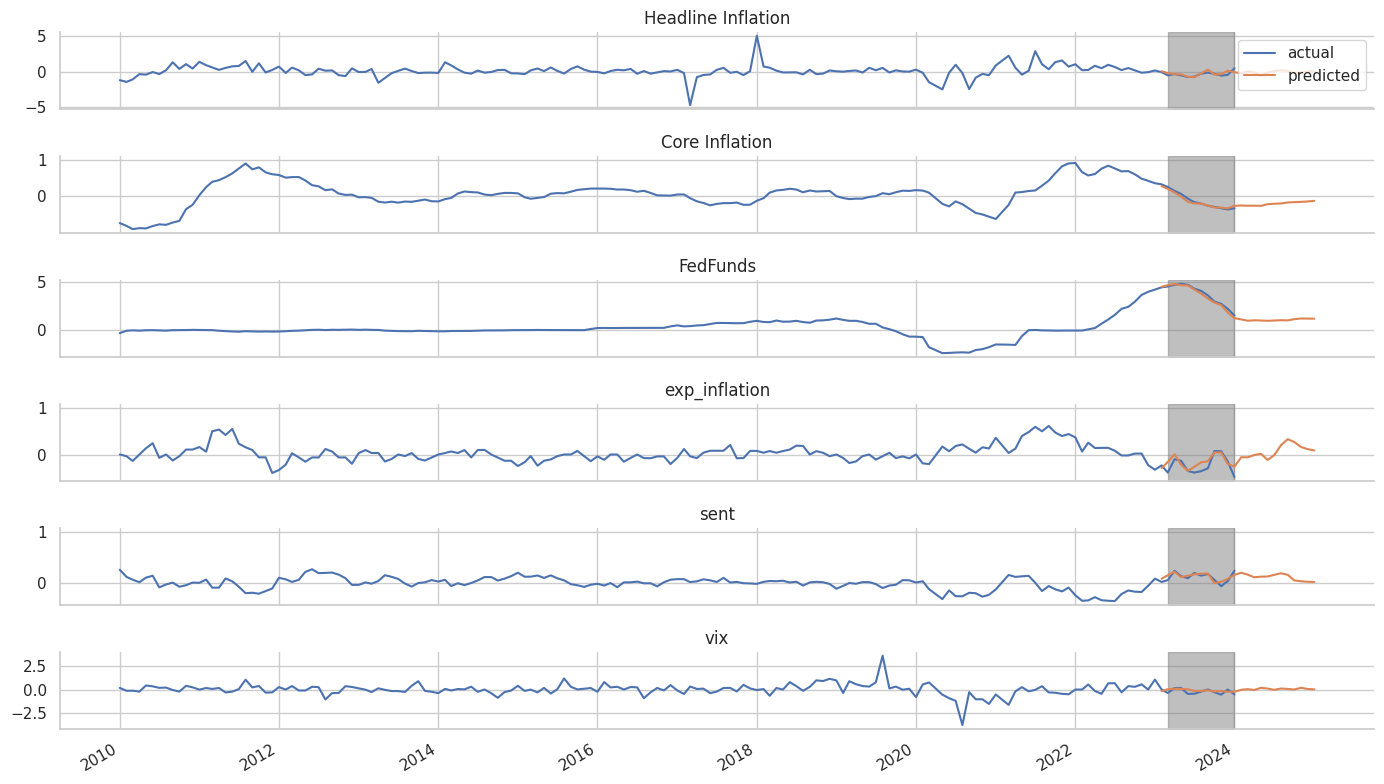

In [ ]:
# Dep. Variable:     ['headline', 'core', 'FedFunds', 'exp_inflation', 'sent', 'vix']   No. Observations:                  393


fig, axes = plt.subplots(nrows=6, figsize=(14, 8), sharex=True)

df_transformed.headline.loc['2010':].plot(ax=axes[0], label='actual', title='Headline Inflation')
preds.headline.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)


trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.core.loc['2010':].plot(ax=axes[1], label='actual', title='Core Inflation')
preds.core.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[2], label='actual', title='FedFunds')
preds.FedFunds.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.exp_inflation.loc['2010':].plot(ax=axes[3], label='actual', title='exp_inflation')
preds.exp_inflation.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[3].transData, axes[4].transAxes)
df_transformed.sent.loc['2010':].plot(ax=axes[4], label='actual', title='sent')
preds.sent.plot(label='predicted', ax=axes[4])
axes[4].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[4].set_xlabel('')




trans = mtransforms.blended_transform_factory(axes[4].transData, axes[5].transAxes)
df_transformed.vix.loc['2010':].plot(ax=axes[5], label='actual', title='vix')
preds.vix.plot(label='predicted', ax=axes[5])
axes[5].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[5].set_xlabel('')






sns.despine()
fig.tight_layout();

core inflation keeps ticking up

expected inflation keeps an uptrend with some fluctuations

sentiment goes up and down

vix is flat?

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

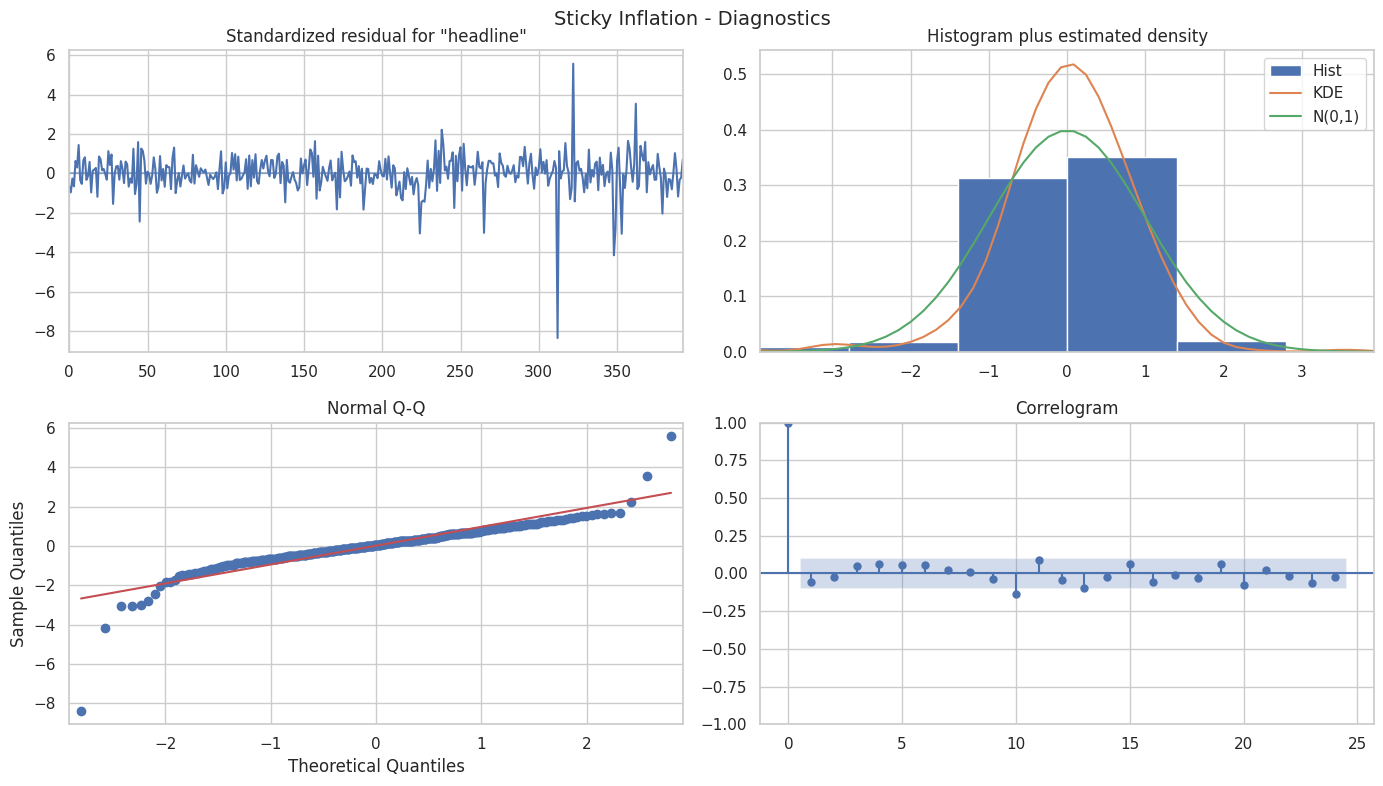

In [ ]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Sticky Inflation - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

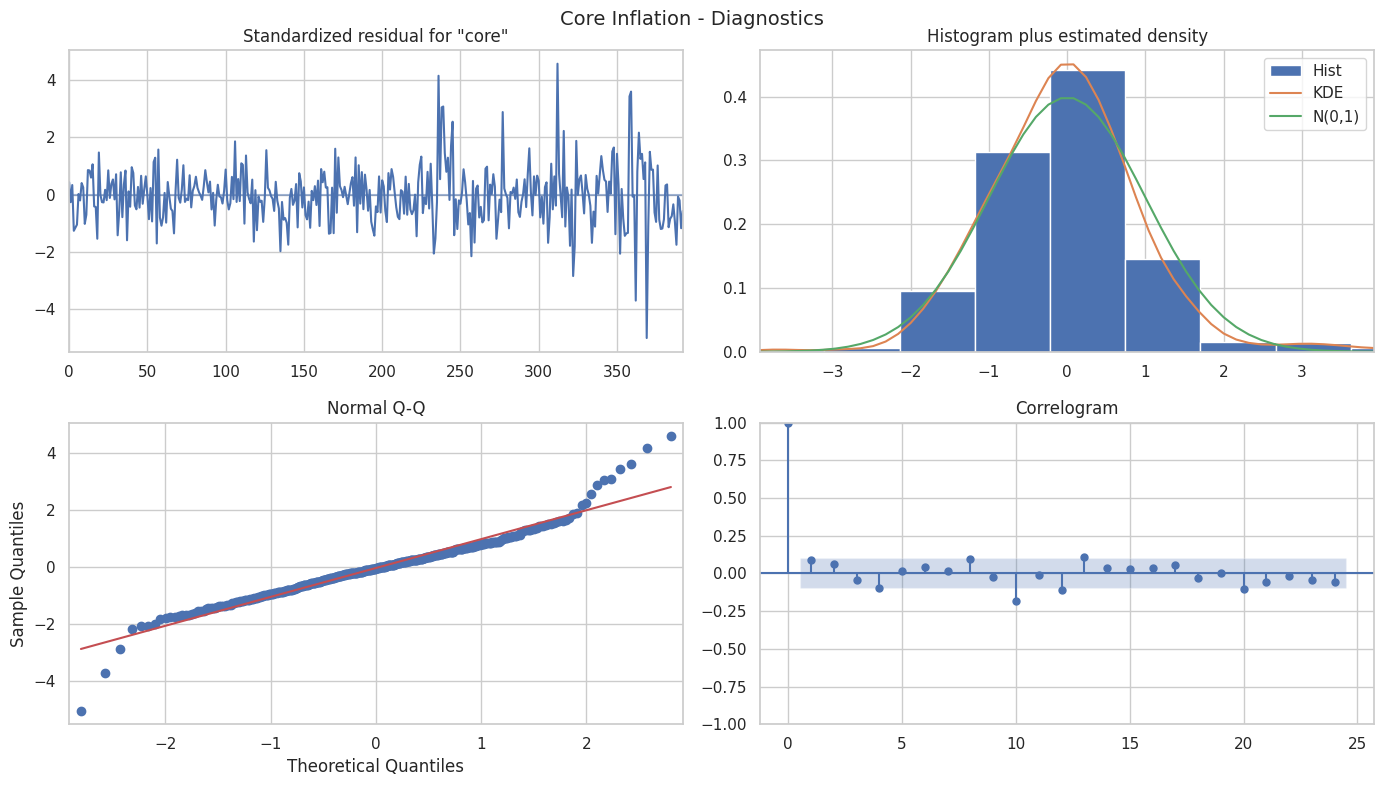

In [ ]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.gcf().suptitle('Core Inflation - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);


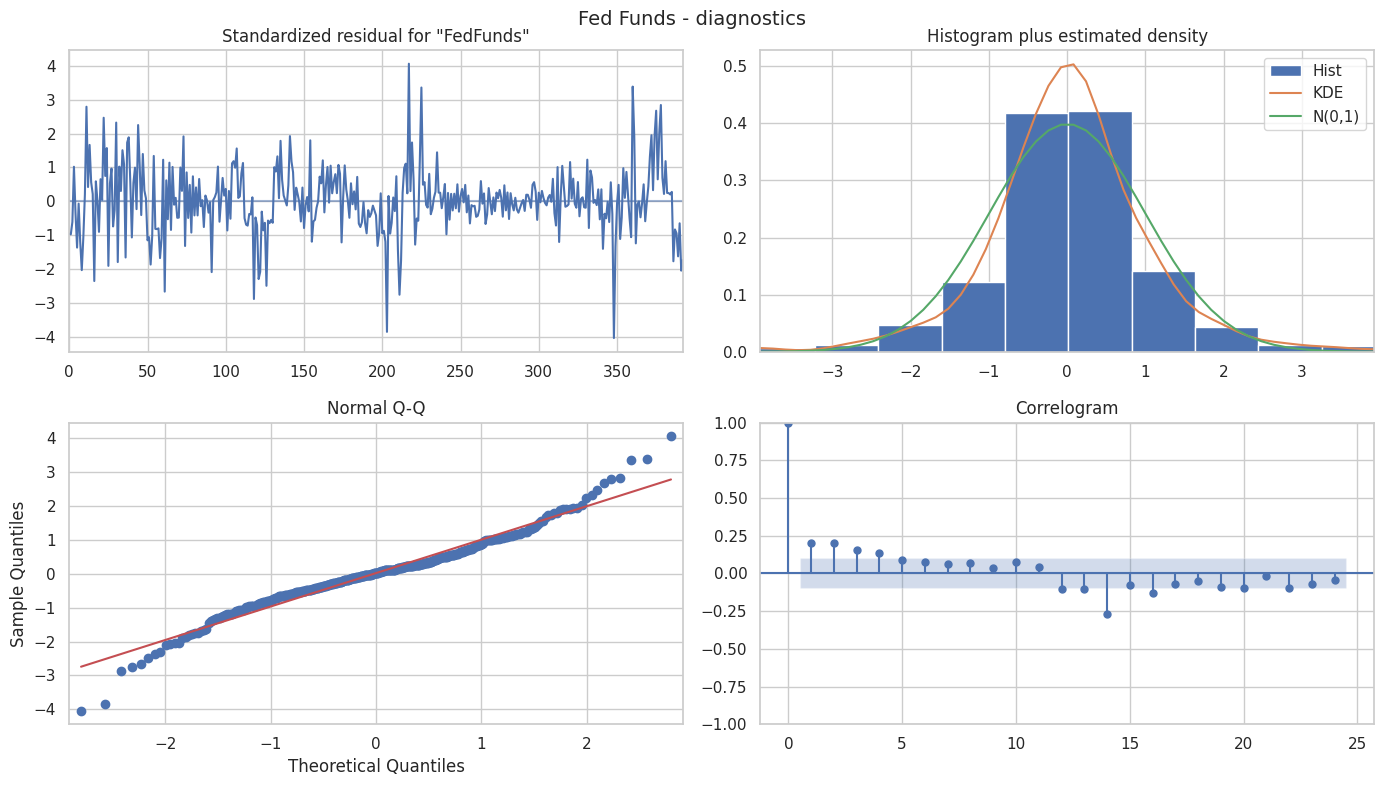

In [ ]:
model.plot_diagnostics(variable=2, figsize=(14,8), lags=24)
plt.gcf().suptitle('Fed Funds - diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

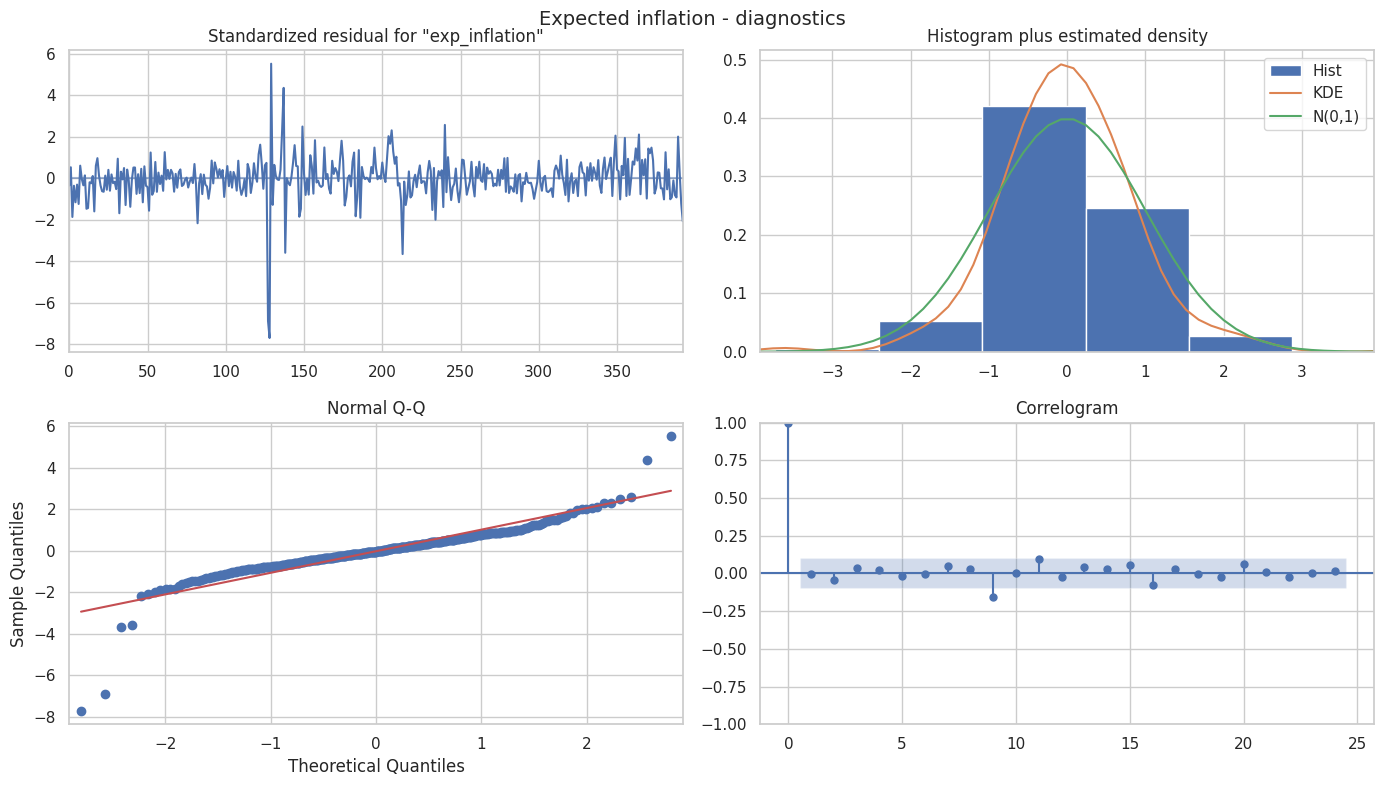

In [ ]:
model.plot_diagnostics(variable=3, figsize=(14,8), lags=24)
plt.gcf().suptitle('Expected inflation - diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

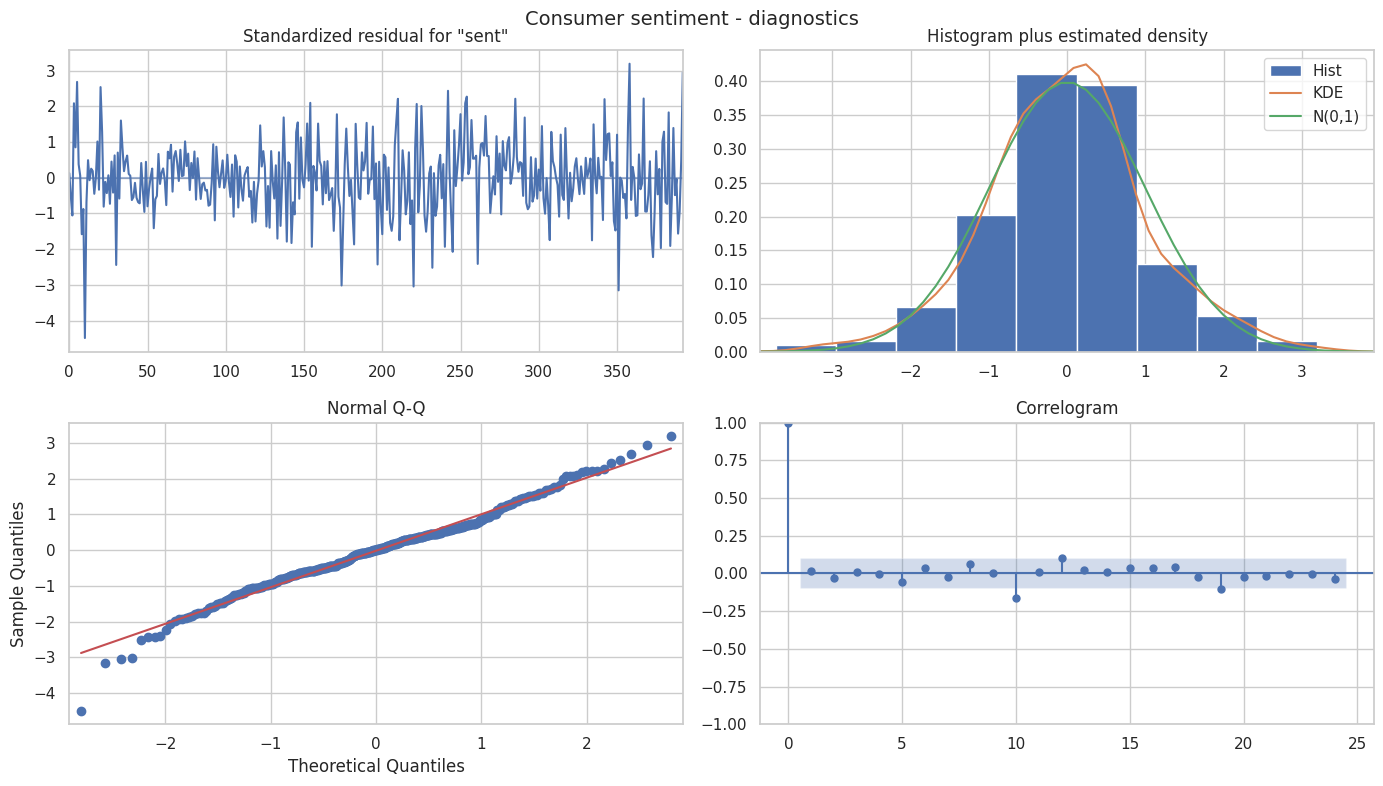

In [ ]:
model.plot_diagnostics(variable=4, figsize=(14,8), lags=24)
plt.gcf().suptitle('Consumer sentiment - diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

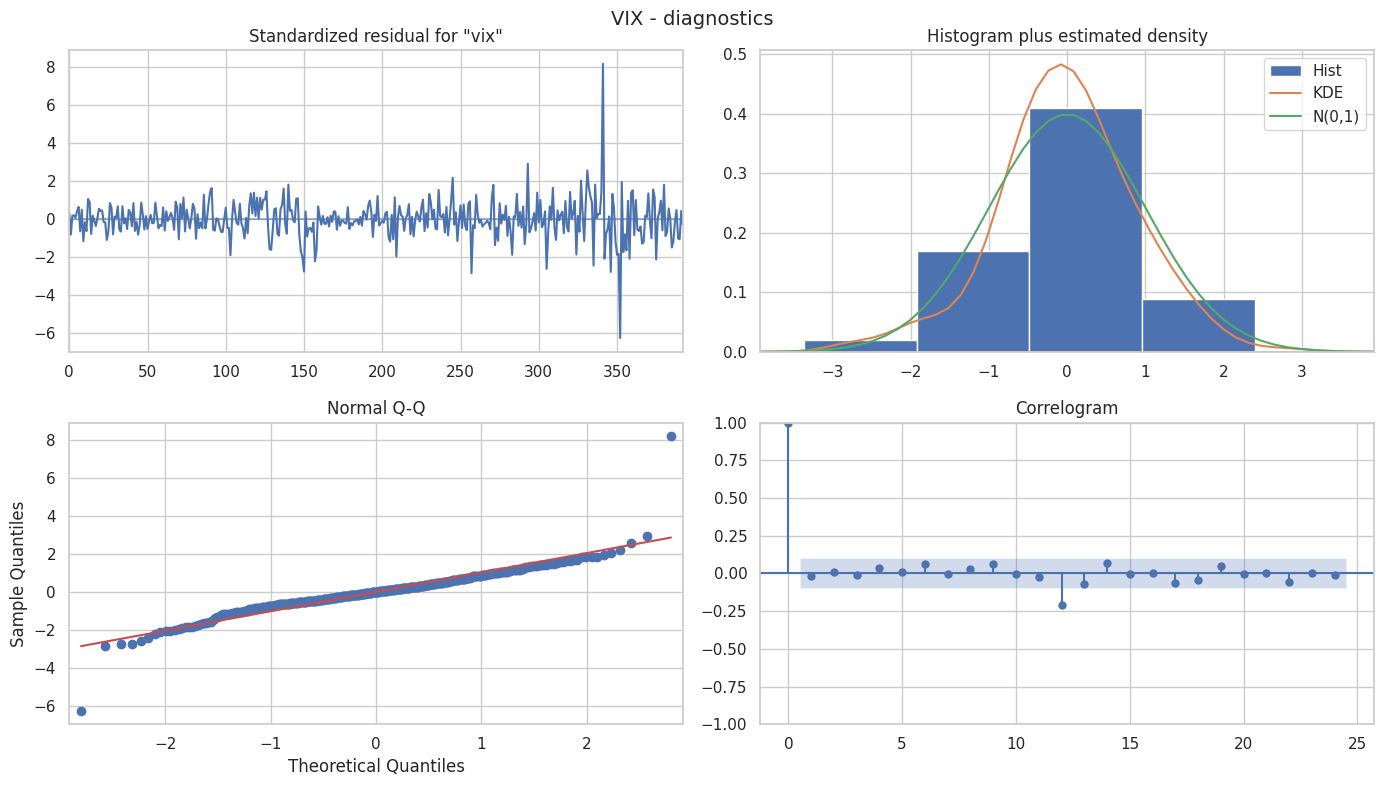

In [ ]:
model.plot_diagnostics(variable=5, figsize=(14,8), lags=24)
plt.gcf().suptitle('VIX - diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

### Impulse-Response Function

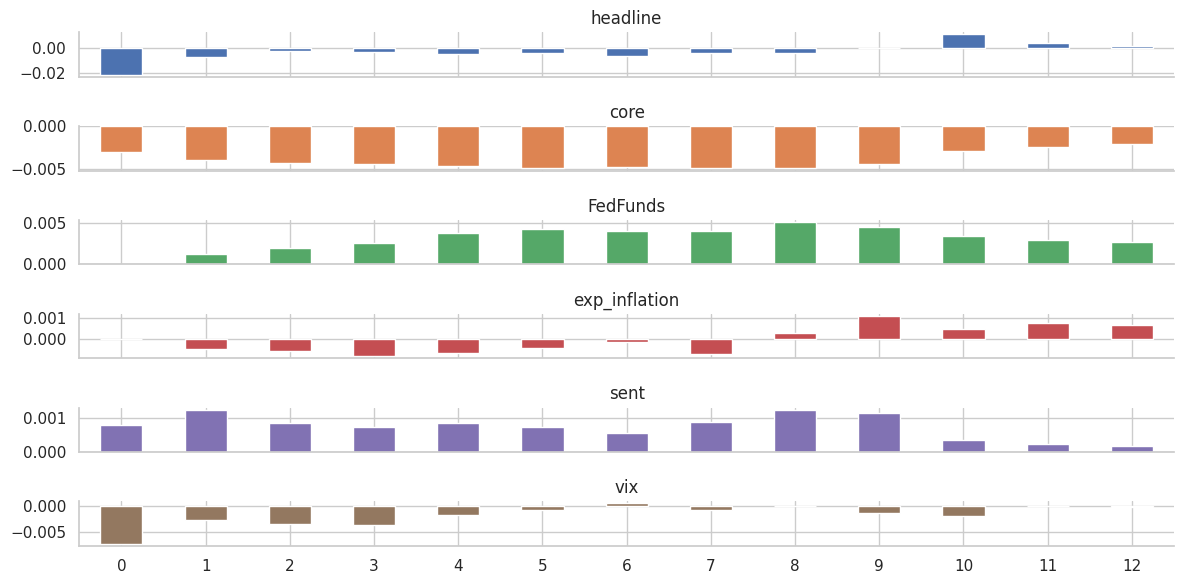

In [ ]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

### Generate Predictions



#### In-sample

Out-of-sample predictions can be generated as follows:

In [ ]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

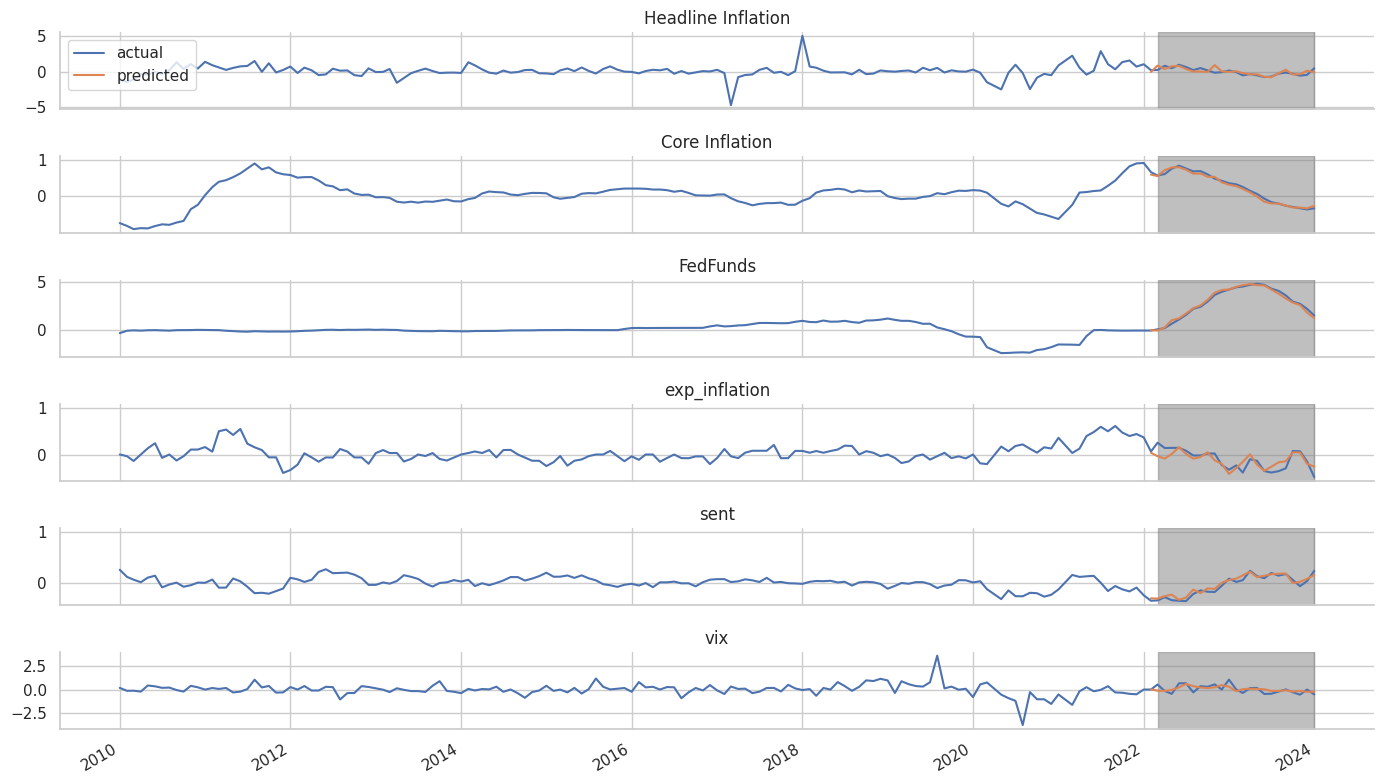

In [ ]:
preds.index = df_transformed.index[start:]


fig, axes = plt.subplots(nrows=6, figsize=(14, 8), sharex=True)

df_transformed.headline.loc['2010':].plot(ax=axes[0], label='actual', title='Headline Inflation')
preds.headline.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)


trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.core.loc['2010':].plot(ax=axes[1], label='actual', title='Core Inflation')
preds.core.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[2], label='actual', title='FedFunds')
preds.FedFunds.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.exp_inflation.loc['2010':].plot(ax=axes[3], label='actual', title='exp_inflation')
preds.exp_inflation.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[3].transData, axes[4].transAxes)
df_transformed.sent.loc['2010':].plot(ax=axes[4], label='actual', title='sent')
preds.sent.plot(label='predicted', ax=axes[4])
axes[4].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[4].set_xlabel('')




trans = mtransforms.blended_transform_factory(axes[4].transData, axes[5].transAxes)
df_transformed.vix.loc['2010':].plot(ax=axes[5], label='actual', title='vix')
preds.vix.plot(label='predicted', ax=axes[5])
axes[5].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[5].set_xlabel('')






sns.despine()
fig.tight_layout();

##### Observations

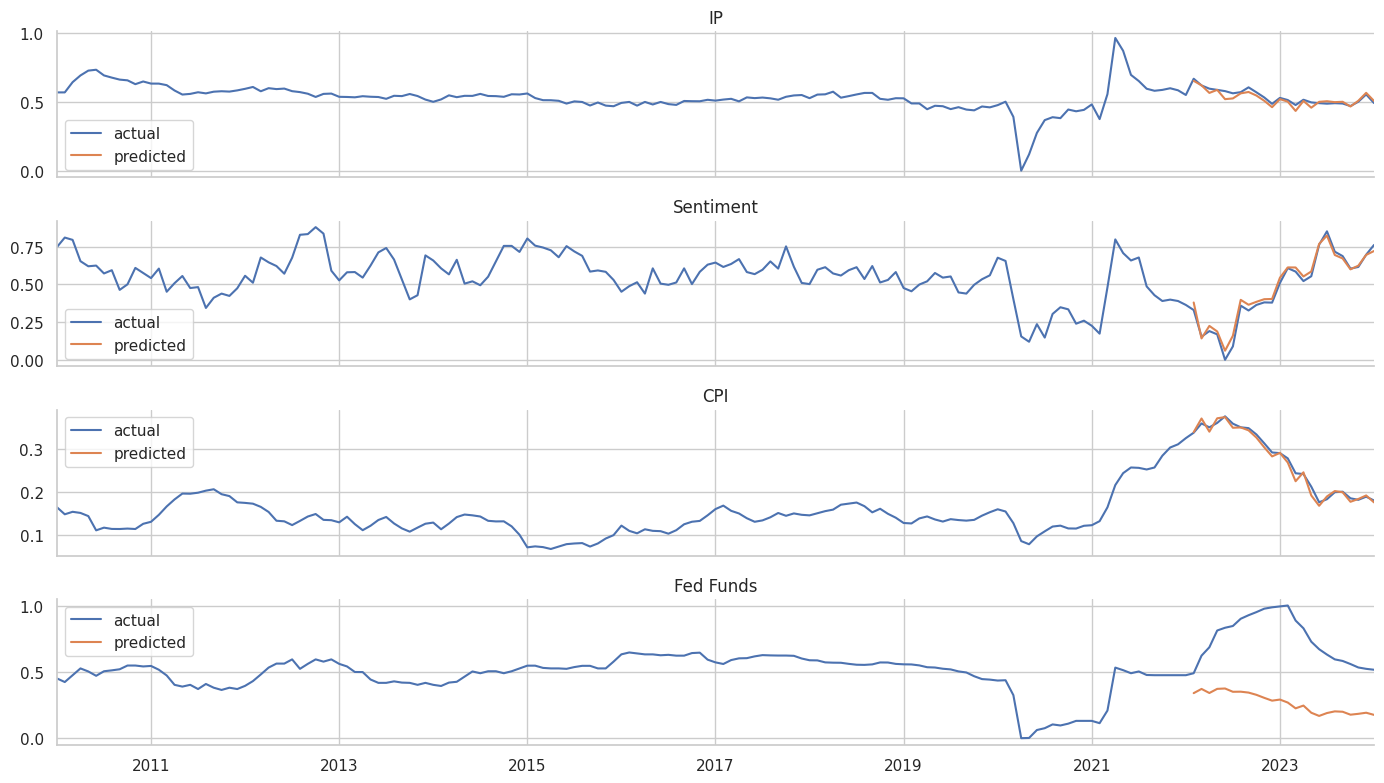

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='IP')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')

df_transformed['2010':].CPI.plot(ax=axes[2], label='actual', title='CPI')
preds.CPI.plot(label='predicted', ax=axes[2])
axes[2].legend()
axes[2].set_xlabel('')


df_transformed['2010':].FedFunds.plot(ax=axes[3], label='actual', title='Fed Funds')
preds.CPI.plot(label='predicted', ax=axes[3])
axes[3].legend()
axes[3].set_xlabel('')


sns.despine()
fig.tight_layout();

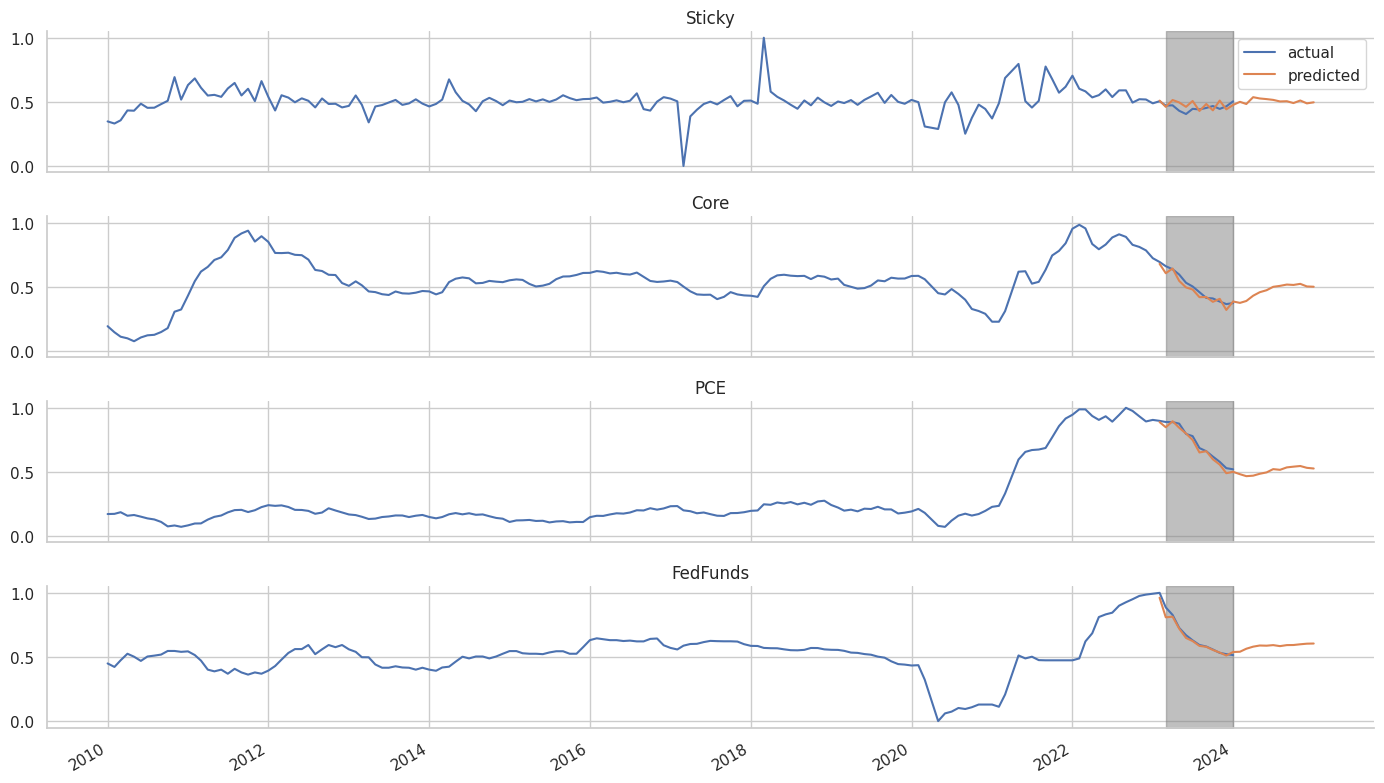

In [ ]:
#preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=4, figsize=(14, 8), sharex=True)


df_transformed.sticky.loc['2010':].plot(ax=axes[0], label='actual', title='Sticky')
preds.sticky.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.core.loc['2010':].plot(ax=axes[1], label='actual', title='Core')
preds.core.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.PCE.loc['2010':].plot(ax=axes[2], label='actual', title='PCE')
preds.PCE.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')

trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[3], label='actual', title='FedFunds')
preds.FedFunds.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')




sns.despine()
fig.tight_layout();

### IP & sentiment & CPI & Fed Funds & core inflation




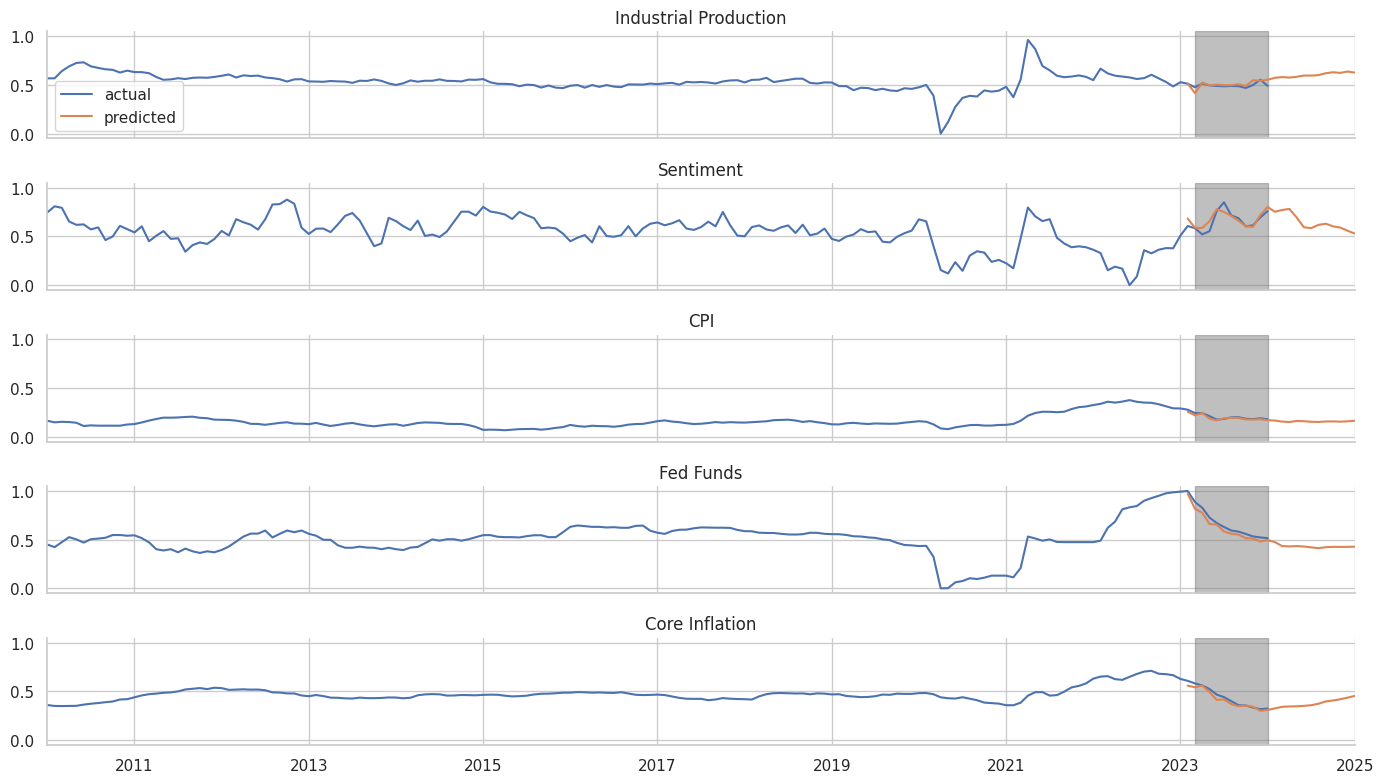

In [ ]:

#preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=5, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.CPI.loc['2010':].plot(ax=axes[2], label='actual', title='CPI')
preds.CPI.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[3], label='actual', title='Fed Funds')
preds.FedFunds.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')

trans = mtransforms.blended_transform_factory(axes[3].transData, axes[4].transAxes)
df_transformed.CoreInflation.loc['2010':].plot(ax=axes[4], label='actual', title='Core Inflation')
preds.CoreInflation.plot(label='predicted', ax=axes[4])
axes[4].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[4].set_xlabel('')


sns.despine()
fig.tight_layout();


### headline & core & PCE & Fed Funds


#### populate the dataframe

In [11]:
df = pd.DataFrame()
df['pce'] = pce
df['FedFunds'] = fedfunds
df['headline_inflation'] = cpi_all
df['core_inflation'] = cpi_core

print(df)
print(df.info())

                pce  FedFunds  headline_inflation  core_inflation
DATE                                                             
1990-01-01   59.181      8.23            0.446445        4.905908
1990-02-01   59.468      8.24            0.392597        4.917559
1990-03-01   59.754      8.28            0.618123        5.191525
1990-04-01   59.932      8.26            0.431722        5.276985
1990-05-01   60.115      8.18            0.382620        5.166732
...             ...       ...                 ...             ...
2023-09-01  119.842      5.33            0.413800        4.959770
2023-10-01  120.015      5.33            0.346680        4.882928
2023-11-01  120.122      5.33            0.288530        4.688293
2023-12-01  120.305      5.33            0.344810        4.554396
2024-01-01  120.849      5.33            0.538316        4.603922

[409 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1990-01-01 to 2024-01-01
Data columns (total 4 colum

In [12]:
df_transformed = pd.DataFrame({
                              'headline': np.log(df.headline_inflation).diff(10),
                              'core': np.log(df.core_inflation).diff(10),
                              'PCE':  np.log(df.pce).diff(12),
                              'FedFunds': (df.FedFunds).diff(14),

                              }).dropna()

#### test stationarity

In [13]:
test_unit_root(df_transformed)

p-value
headline   0.00%
core       0.00%
PCE        2.02%
FedFunds   0.05%

#### plotting

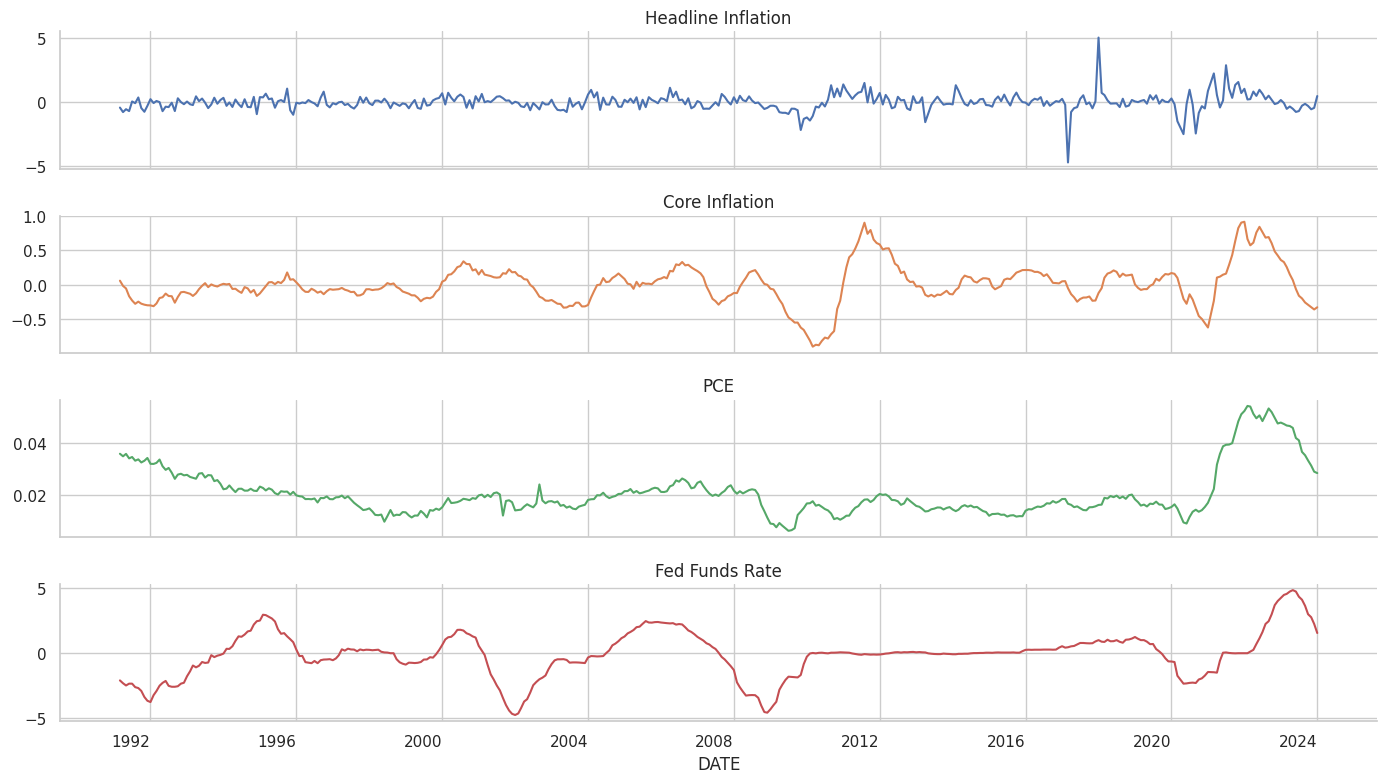

In [ ]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Headline Inflation', 'Core Inflation', 'PCE', 'Fed Funds Rate'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

#### corre

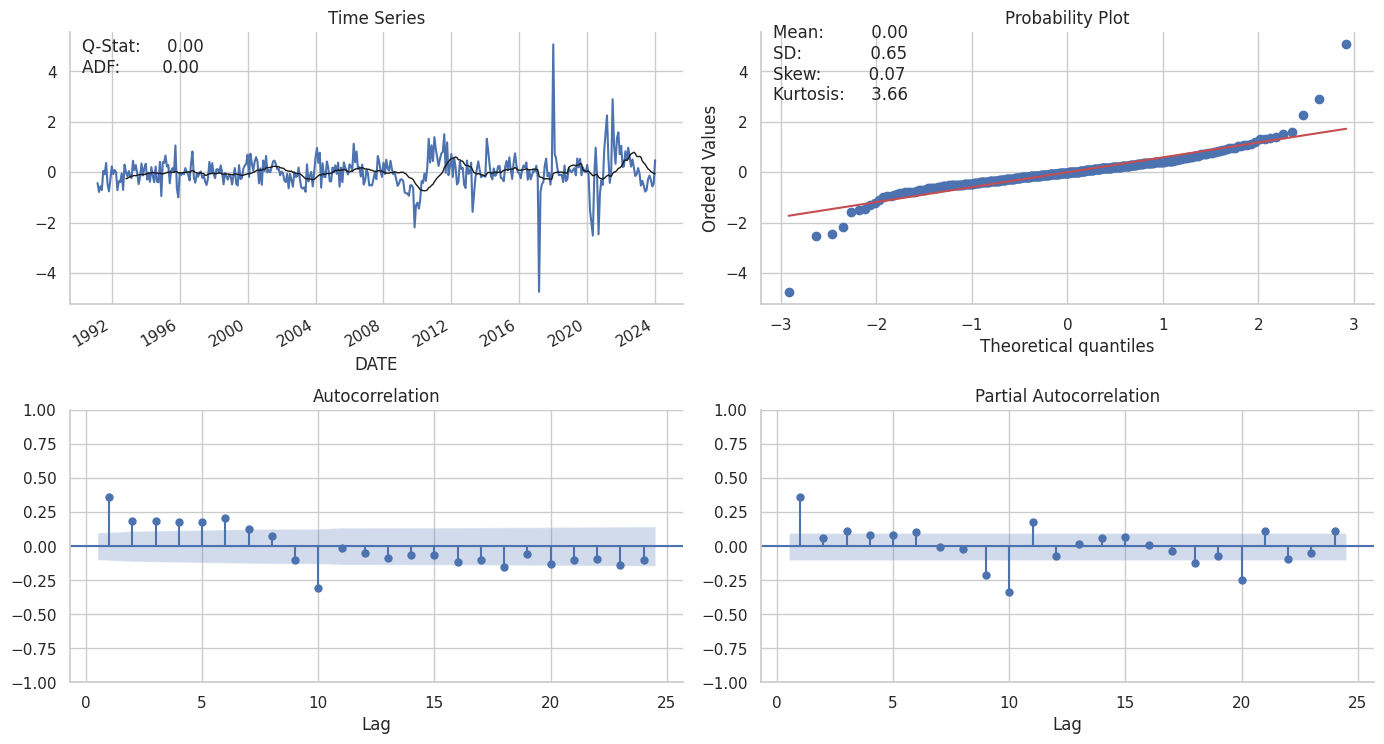

In [ ]:
plot_correlogram(df_transformed.headline, lags=24)

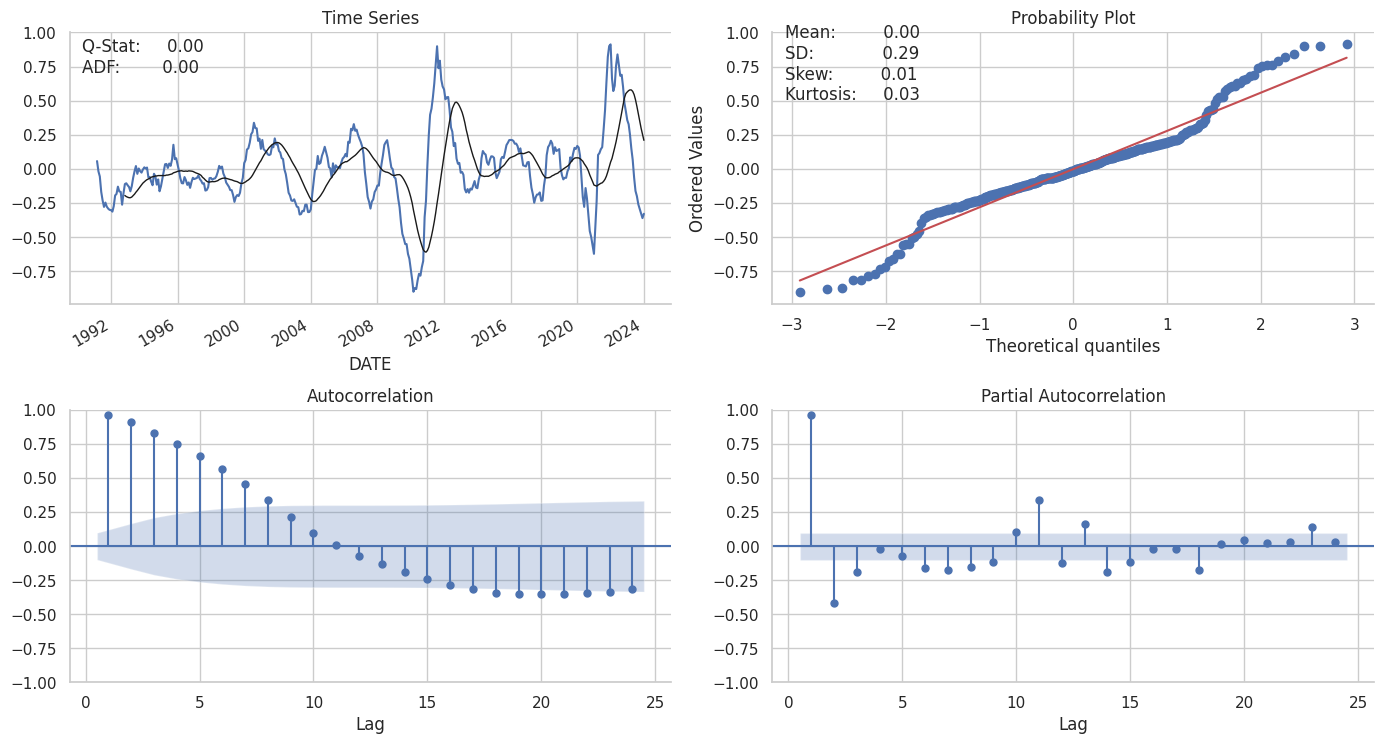

In [ ]:
plot_correlogram(df_transformed.core, lags=24)

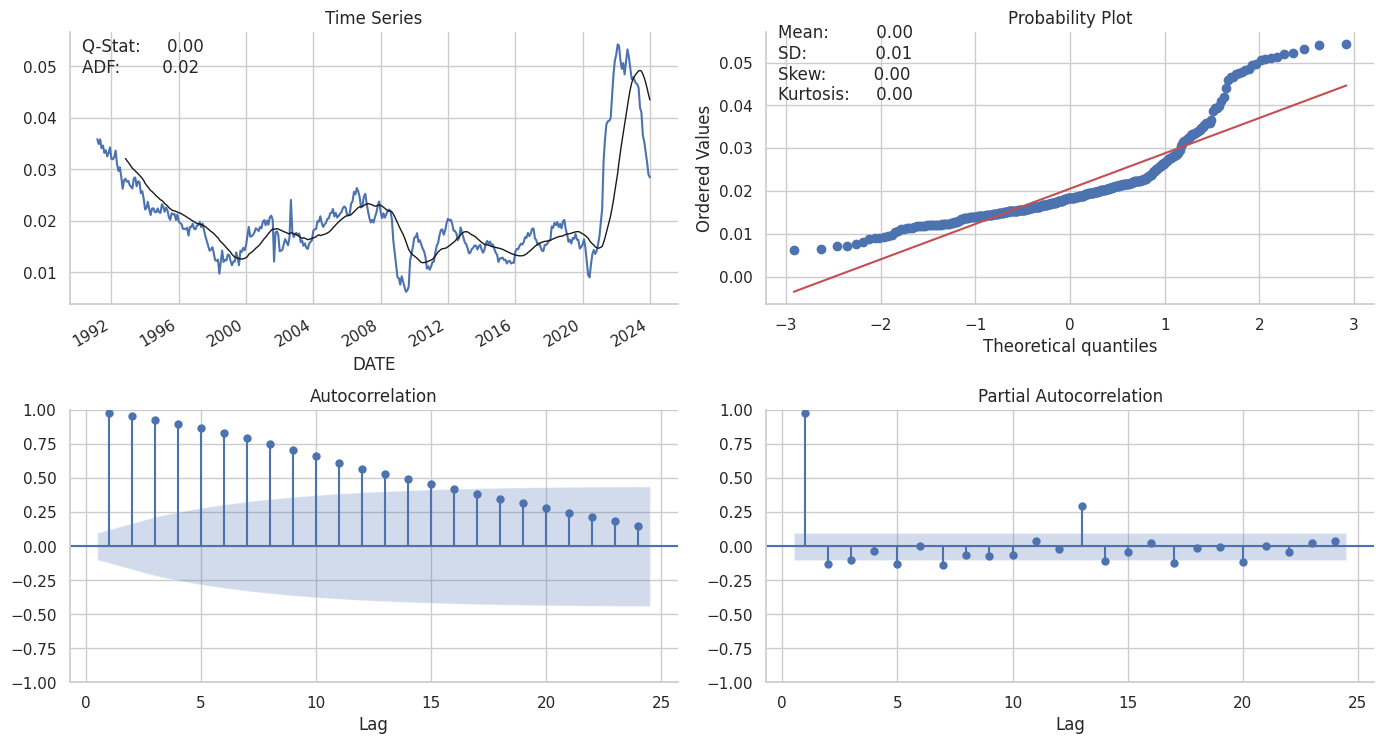

In [ ]:
plot_correlogram(df_transformed.PCE, lags=24)

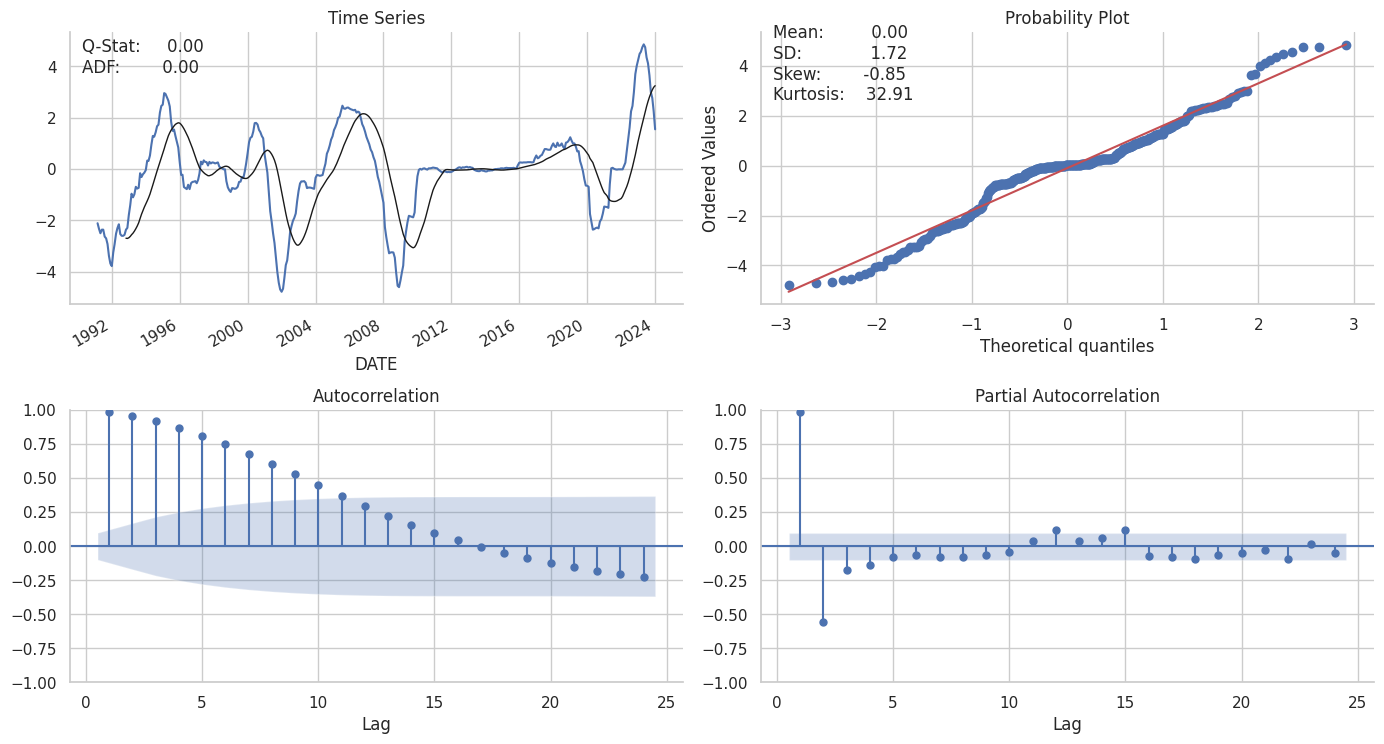

In [ ]:
plot_correlogram(df_transformed.FedFunds, lags=24)

#### train the model

In [14]:
print(df_transformed)
df_transformed = df_transformed.apply(minmax_scale)


            headline      core       PCE  FedFunds
DATE                                              
1991-03-01 -0.431756  0.057821  0.035865     -2.11
1991-04-01 -0.787494 -0.017759  0.034891     -2.33
1991-05-01 -0.559406 -0.054797  0.035814     -2.50
1991-06-01 -0.708888 -0.167809  0.034094     -2.36
1991-07-01  0.048664 -0.229673  0.034616     -2.36
...              ...       ...       ...       ...
2023-09-01 -0.137806 -0.258455  0.035295      3.65
2023-10-01 -0.304565 -0.291912  0.033277      3.00
2023-11-01 -0.564914 -0.324817  0.031329      2.77
2023-12-01 -0.457278 -0.359548  0.028985      2.25
2024-01-01  0.472973 -0.327974  0.028435      1.55

[393 rows x 4 columns]


In [15]:
test_unit_root(df_transformed)
model = VARMAX(df_transformed.loc[:'2024'], order=(1,11), trend='c').fit(maxiter=100, disp=True)

In [17]:
print(model.summary())

                                      Statespace Model Results                                     
Dep. Variable:     ['headline', 'core', 'PCE', 'FedFunds']   No. Observations:                  393
Model:                                         VARMA(1,11)   Log Likelihood                3255.106
                                               + intercept   AIC                          -6098.212
Date:                                     Sat, 06 Apr 2024   BIC                          -5279.607
Time:                                             06:22:22   HQIC                         -5773.809
Sample:                                                  0                                         
                                                     - 393                                         
Covariance Type:                                       opg                                         
Ljung-Box (L1) (Q):     0.45, 0.35, 0.45, 0.18   Jarque-Bera (JB):   6183.04, 85.59, 238.32, 140.48


#### out-of-sample prediction

In [18]:
n =len(df_transformed)
start = n-12

preds = model.predict(start=start+1, end=start + 24)
# Get the start index from df_transformed
start_index = df_transformed.index[start:]
print(df_transformed.index[start:].shape)
print(preds)
print(df_transformed[start:])
# Get the start index from df_transformed
start_index = df_transformed.index[start:]

# Create a new index for preds using start_index values
new_index = pd.Index([start_index[i] for i in range(min(24, len(start_index)))])
print("new_index ", new_index)

extension_dates = pd.date_range(start='2024-02-01', periods=12, freq='MS')
print("extension ", extension_dates)
# Append the extension_dates to new_index
new_index = new_index.append(extension_dates)
print("new_index after ext ", new_index)
# Assign the new index to preds
preds.index = new_index
print(preds)

(12,)
     headline      core       PCE  FedFunds
382  0.458314  0.638746  0.837731  0.974328
383  0.441607  0.590227  0.832387  0.986147
384  0.474401  0.581336  0.812054  0.995646
385  0.432963  0.472215  0.795190  0.986977
386  0.448743  0.412398  0.727622  0.982313
387  0.430940  0.390611  0.710789  0.932362
388  0.479527  0.397496  0.591250  0.905598
389  0.545993  0.392489  0.581190  0.839671
390  0.447719  0.317783  0.527980  0.782588
391  0.447609  0.284258  0.482905  0.775461
392  0.461596  0.280042  0.464170  0.703476
393  0.447088  0.315238  0.441374  0.636137
394  0.498787  0.344238  0.432734  0.611047
395  0.520619  0.371637  0.444638  0.587221
396  0.487198  0.387340  0.425760  0.580656
397  0.469374  0.399818  0.412149  0.586563
398  0.509174  0.427606  0.400191  0.581249
399  0.548164  0.457770  0.399358  0.584636
400  0.516519  0.464288  0.397762  0.581266
401  0.526613  0.489182  0.404192  0.578514
402  0.469219  0.488645  0.418800  0.590428
403  0.467456  0.475958  0

##### PLOT

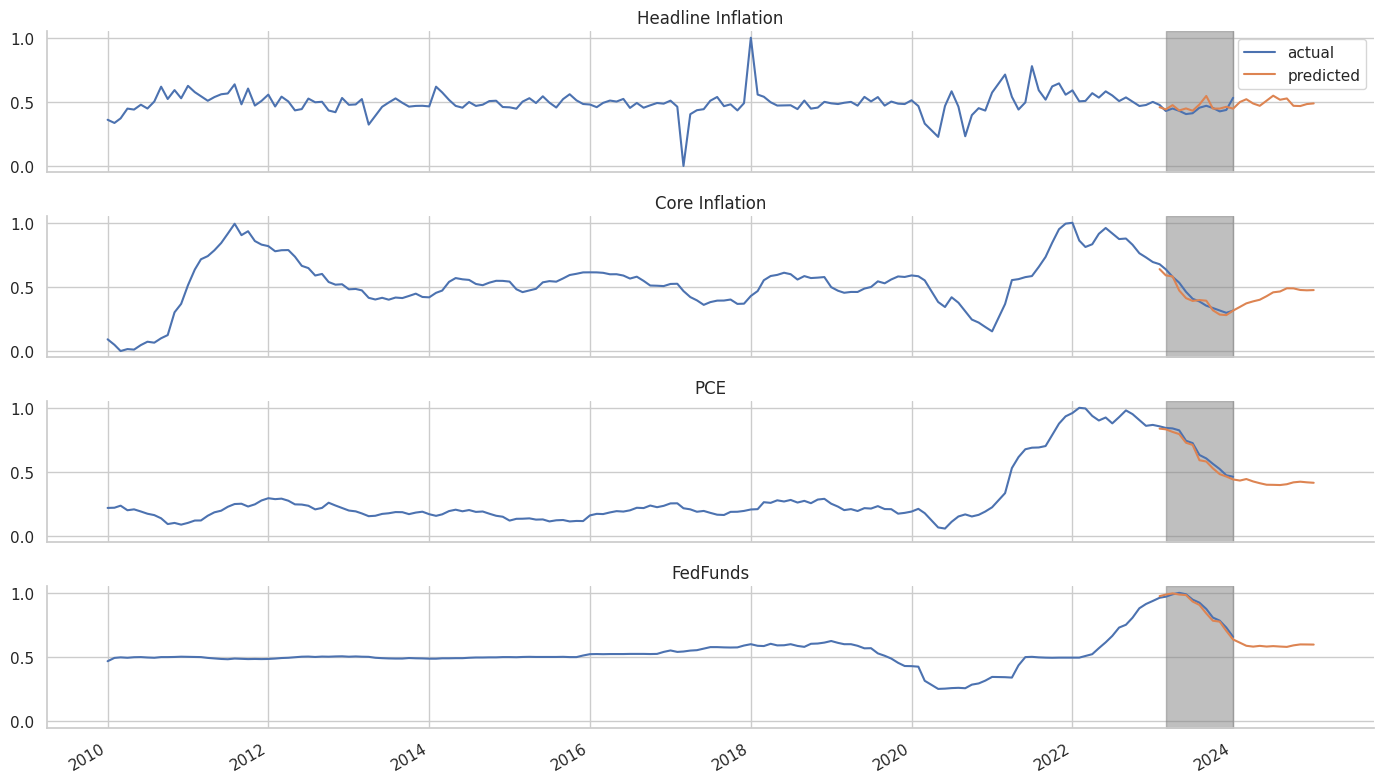

In [19]:
# Dep. Variable:     ['headline', 'core', 'PCE', 'FedFunds']


fig, axes = plt.subplots(nrows=4, figsize=(14, 8), sharex=True)

df_transformed.headline.loc['2010':].plot(ax=axes[0], label='actual', title='Headline Inflation')
preds.headline.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)


trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.core.loc['2010':].plot(ax=axes[1], label='actual', title='Core Inflation')
preds.core.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')



trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.PCE.loc['2010':].plot(ax=axes[2], label='actual', title='PCE')
preds.PCE.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[3], label='actual', title='FedFunds')
preds.FedFunds.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')




sns.despine()
fig.tight_layout();

#####
we can compare this result with "headline & core & FedFunds & exp_inflation & sent & vix" and we see the uptrend of core inflation may be more significant.

#### in-sample prediction

In [22]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

##### PLOT

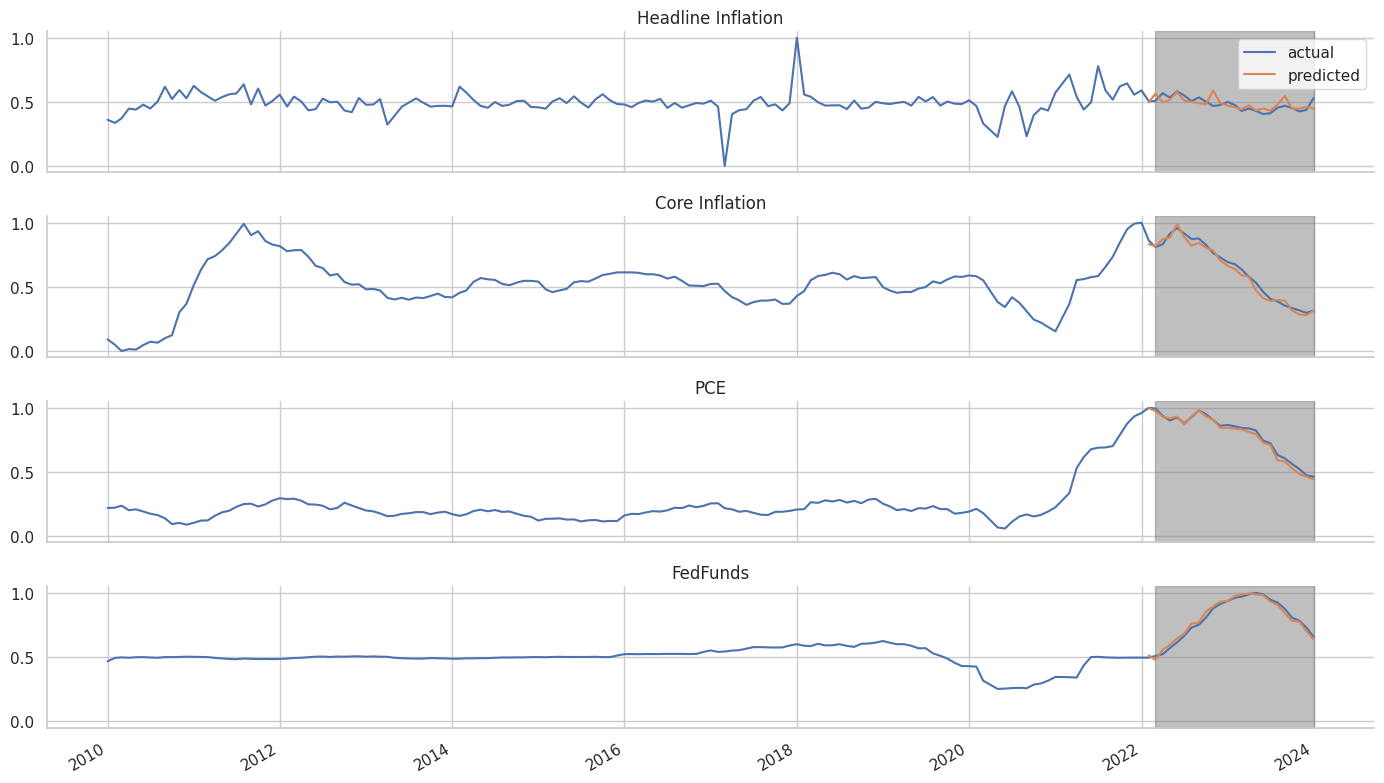

In [24]:
preds.index = df_transformed.index[start:]


fig, axes = plt.subplots(nrows=4, figsize=(14, 8), sharex=True)

df_transformed.headline.loc['2010':].plot(ax=axes[0], label='actual', title='Headline Inflation')
preds.headline.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)


trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.core.loc['2010':].plot(ax=axes[1], label='actual', title='Core Inflation')
preds.core.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')



trans = mtransforms.blended_transform_factory(axes[1].transData, axes[2].transAxes)
df_transformed.PCE.loc['2010':].plot(ax=axes[2], label='actual', title='PCE')
preds.PCE.plot(label='predicted', ax=axes[2])
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[2].set_xlabel('')


trans = mtransforms.blended_transform_factory(axes[2].transData, axes[3].transAxes)
df_transformed.FedFunds.loc['2010':].plot(ax=axes[3], label='actual', title='FedFunds')
preds.FedFunds.plot(label='predicted', ax=axes[3])
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[3].set_xlabel('')




sns.despine()
fig.tight_layout();

# Summary

in any case, core inflation still has not been brought down - see the figures above